# 소개

### **멋쟁이 사자처럼 6기 데이터톤 프로젝트**

### **8TEAM : 갓 잡아올린 참치처럼 팔팔해~**

### **정우정(팀장) 소형선, 이도권, 한승헌**


**사용하는 데이터셋**

통합데이터셋(dataton).csv
* Kaggle에서 제공해주는 Google Merchandise Sales Data이다.
* userid를 익명화하여 나타냈으며,상품에 대한 카테고리, 가격 등에 대한 정보가 나타나있다.
* 타입에 대한 데이터에는 'add_to_cart', 'begin_checkout', 'purchase'로 구성이 되어있다
* 2020.11.01~2021.02.01 기간의 데이터셋이다
* 본 코랩에서 'data_ka'라는 변수명으로 불러온다

통합데이터셋_bq(dataton).csv
* Google의 BigQuery에서 SQL을 사용하여 필요한 컬럼을 기반으로 추출한 데이터이다
* 타입에 대한 데이터는 캐글의 데이터보다 세분화되어 여러 절차로 구성이 되어 있다
* 2020.11.01~2021.02.01 기간의 데이터셋이다
* 본 코랩에서는 'data_bq'라는 변수명으로 불러온다

dataton_분석데이터.csv
* '통합데이터셋_bq(dataton).csv'를 가공처리해서 저장한 데이터셋
* 본 코랩에서는 'store'라는 변수명으로 불러온다

**필수 실행 코드**

한글 깨짐 방지 코드

In [ ]:
#한글 글씨 폰트 설치
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

마이너스 방지 코드

In [ ]:
plt.rcParams['axes.unicode_minus'] = False


# 1. 문제 정의

Google Merchandise Store는 2020년 12월을 기준으로 전 세계 검색엔진 시장에서 91.4%의 수준의 압도적인 브랜드 인지도를 가지고 있다.

반면에, Google Merchandise Store의 존재를 인지하지 못하는 사용자가 다수인 것으로 나타났다.

2020년의 전 세계 이커머스의 시장에서의 구매 전환율이 2.86%인 것에 반해, Google Merchandise Store의 전환율은 1.5% 수준으로 평균보다 낮다는 점을 확인할 수 있다.

# 2. 고객 여정 지도

전체 click, begin_checkout 등을 포함한 17개의 종류의 타입에서 핵심적인 5개의 타입을 추출하여 전환율을 확인

5개의 핵심 타입

* page_view : 웹페이지 노출된 첫 화면 보기
* view_item : 상품 상세 화면 열람
* select_item : 특정 상품 선택
* add_to_cart : 장바구니 담기
* purchase : 구매

**핵심 5단계의 단계별 전환율 확인**

In [ ]:
# 데이터 불러오기
import pandas as pd
data_bq = pd.read_csv("/content/통합데이터셋_bq(dataton).csv")

In [ ]:
data_bq.shape

(271554, 13)

In [ ]:
data_bq['타입'].nunique()

16

In [ ]:
# 날짜 변환
data_bq['이벤트발생시간'] = pd.to_datetime(data_bq['이벤트발생시간'], errors='coerce')
data_bq = data_bq.dropna(subset=['이벤트발생시간']).copy()
data_bq['event_date'] = data_bq['이벤트발생시간'].dt.normalize()

In [ ]:
# 퍼널 단계 정의
funnel_events = {
    "방문하기": ["page_view"],
    "상품보기": ["view_item"],
    "상품탐색": ["select_item"],
    "장바구니담기": ["add_to_cart"],
    "결제": ["purchase"]
}


In [ ]:
# 전체 사용자 기준 집계
subset = data_bq.copy()

# 단계별 사용자 수 계산
funnel_counts = {}
for step, events in funnel_events.items():
    funnel_counts[step] = subset[subset["타입"].isin(events)]["사용자ID"].nunique()

In [ ]:
# 단계별 전환율 계산
funnel_rates = {}
steps = list(funnel_events.keys())

# 첫 단계(‘방문하기’)는 이전 단계가 없으므로 NA 처리
funnel_rates[steps[0]] = pd.NA

# 이후 단계별 전환율 계산 (100×%)
for i in range(1, len(steps)):
    prev_step = steps[i - 1]
    curr_step = steps[i]
    prev = funnel_counts.get(prev_step, 0)
    curr = funnel_counts.get(curr_step, 0)
    funnel_rates[curr_step] = round((curr / prev) * 100, 2) if prev > 0 else pd.NA

# 방문 → 구매 전체 전환율 (%)
total_conversion_rate = (
    round((funnel_counts["결제"] / funnel_counts["방문하기"]) * 100, 2)
    if funnel_counts["방문하기"] > 0 else pd.NA
)

In [ ]:
# 결과 정리
print("[전체 사용자 퍼널 절대 수치]")
display(pd.DataFrame([funnel_counts]))

print("\n[전 단계 대비 및 전체 전환율 (% 단위)]")
rate_df = pd.DataFrame([funnel_rates])
rate_df["total_conversion_rate(%)"] = total_conversion_rate
display(rate_df)

[전체 사용자 퍼널 절대 수치]


,방문하기,상품보기,상품탐색,장바구니담기,결제
0,10031,2102,609,524,140



[전 단계 대비 및 전체 전환율 (% 단위)]


,방문하기,상품보기,상품탐색,장바구니담기,결제,total_conversion_rate(%)
0,<NA>,20.96,28.97,86.04,26.72,1.4


| 방문하기 | 상품보기 | 상품탐색 | 장바구니담기 | 결제 | total_conversion_rate(%) |
|-----------|-----------|-----------|---------------|--------|---------------------------|
| <NA> | 21.25 | 29.19 | 88.03 | 28.06 | 1.53 |


개선해야하는 구간 우선 순위 설정(이탈율 기준, 이탈율 = 100 - 전환율)

* 1. 방문하기 -> 상품보기 : 79%
* 2. 장바구니담기 -> 결제 : 72%
* 3. 상품보기 -> 상품탐색 : 71%
* 4. 상품탐색 -> 장바구니담기 : 12%

In [ ]:
# 날짜 변환
data_bq['이벤트발생시간'] = pd.to_datetime(data_bq['이벤트발생시간'], errors='coerce')
data_bq = data_bq.dropna(subset=['이벤트발생시간']).copy()
data_bq['event_date'] = data_bq['이벤트발생시간'].dt.normalize()

# 퍼널 단계 정의
funnel_events = {
    "방문하기": ["page_view"],
    "상품보기": ["view_item"],
    "상품탐색": ["select_item"],
    "장바구니담기": ["add_to_cart"],
    "결제": ["purchase"]
}

# 전체 사용자 기준 집계
subset = data_bq.copy()

# 단계별 사용자 수 계산
funnel_counts = {}
for step, events in funnel_events.items():
    funnel_counts[step] = subset[subset["타입"].isin(events)]["사용자ID"].nunique()

# 단계별 전환율 계산
funnel_rates = {}
steps = list(funnel_events.keys())

# 첫 단계(‘방문하기’)는 이전 단계가 없으므로 NA 처리
funnel_rates[steps[0]] = pd.NA

# 이후 단계별 전환율 계산 (100×%)
for i in range(1, len(steps)):
    prev_step = steps[i - 1]
    curr_step = steps[i]
    prev = funnel_counts.get(prev_step, 0)
    curr = funnel_counts.get(curr_step, 0)
    funnel_rates[curr_step] = round((curr / prev) * 100, 2) if prev > 0 else pd.NA

# 방문 → 구매 전체 전환율 (%)
total_conversion_rate = (
    round((funnel_counts["결제"] / funnel_counts["방문하기"]) * 100, 2)
    if funnel_counts["방문하기"] > 0 else pd.NA
)

# 결과 정리
print("[전체 사용자 퍼널 절대 수치]")
display(pd.DataFrame([funnel_counts]))

print("\n[전 단계 대비 및 전체 전환율 (% 단위)]")
rate_df = pd.DataFrame([funnel_rates])
rate_df["total_conversion_rate(%)"] = total_conversion_rate
display(rate_df)

[전체 사용자 퍼널 절대 수치]


,방문하기,상품보기,상품탐색,장바구니담기,결제
0,10031,2102,609,524,140



[전 단계 대비 및 전체 전환율 (% 단위)]


,방문하기,상품보기,상품탐색,장바구니담기,결제,total_conversion_rate(%)
0,<NA>,20.96,28.97,86.04,26.72,1.4


**퍼널 Sankey 다이어그램**

In [ ]:
# ====================================
# 🔹 남색 톤 통일 Sankey 다이어그램
# ====================================
import plotly.graph_objects as go

# 1️⃣ 단계별 전환율 (%)
rates = {
    "상품보기": 21.25,   # 방문 → 상품보기
    "상품탐색": 29.22,   # 상품보기 → 상품탐색
    "장바구니담기": 87.97, # 상품탐색 → 장바구니
    "결제": 28.07        # 장바구니 → 결제
}

# 2️⃣ 기준값 (100명 또는 100,000명 등)
N0 = 100_000

# 3️⃣ 단계별 계산
N_visit   = N0
N_view    = N_visit   * (rates["상품보기"]   / 100)
N_select  = N_view    * (rates["상품탐색"]   / 100)
N_cart    = N_select  * (rates["장바구니담기"] / 100)
N_buy     = N_cart    * (rates["결제"]       / 100)

# 4️⃣ 노드와 연결 정의
nodes = ["방문", "상품보기", "상품탐색", "장바구니", "결제"]

sources = [0, 1, 2, 3]
targets = [1, 2, 3, 4]
values  = [N_view, N_select, N_cart, N_buy]

# 5️⃣ Sankey 생성 (남색 계열로 통일)
fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="rgba(0,0,0,0.2)", width=1),
        label=nodes,
        color=[
            "#1F4E79", "#2F5597", "#3B6AA0", "#4A86C5", "#6D9EEB"  # 남색 계열
        ]
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=[
            "rgba(31,78,121,0.45)",
            "rgba(47,85,151,0.45)",
            "rgba(59,106,160,0.45)",
            "rgba(77,121,191,0.55)"
        ],
        label=[
            f"전환율 {rates['상품보기']}%",
            f"전환율 {rates['상품탐색']}%",
            f"전환율 {rates['장바구니담기']}%",
            f"전환율 {rates['결제']}%"
        ]
    )
)])

fig.update_layout(
    title=dict(
        text=f"방문→상품보기→상품탐색→장바구니→결제 전환 퍼널 (기준 {N0:,}명)",
        x=0.5, xanchor="center"
    ),
    font=dict(size=12, color="#1F4E79"),
    plot_bgcolor="white",
    paper_bgcolor="white"
)
fig.show()


# 3. 가설 설정


이탈율 기준 고객 여정지도 우선 순위를 기반하여 작성

**방문하기 -> 상품보기**
* 가설1 : 동일한 세션 내에 유입경로가 referral인 경우가 다른 유입경로보다 상품보기로의 전환율이 높아질 것이다
* 가설2 : 체류시간이 길어질수록 상품보기의 전환율이 높아질 것이다

**장바구니 담기 -> 결제**
* 가설3 : 장바구니에 상품이 담긴 시간을 기준으로, 24시간 이내 구매 전환율이 50%보다 높다
* 가설4 : 서로 다른 날짜에 반복 구매한 재구매자는 하루 동안만 구매한 단일구매자보다 더 다양한 카테고리의 상품을 구매할 것이다.

**상품보기 -> 상품탐색**
* 가설5 : 신규 1회 방문자가 다른 사용자 분류보다 탐색 전환율이 낮을 것이다

**상품탐색 -> 장바구니담기**
* 가설6: 세션당 상품 탐색 수가 많을수록 장바구니에 담길 확률이 높다
* 가설7 : 유저타입에 따라 장바구니 전환율이 다를 것이다

# 4. 데이터 전처리

## 4-1. 데이터 불러오기

In [ ]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import pytz

In [ ]:
data_bq = pd.read_csv('/content/통합데이터셋_bq(dataton).csv')
data_bq

,사용자ID,세션_식별자,유입출처,유입유형,캠페인명,국가,지역,도시,기기,타입,상품ID,이벤트발생시간,상품명
0,8.014384e+06,7289119443,(direct),(none),(direct),India,Uttar Pradesh,Noida,mobile,add_payment_info,NaN,2021-01-20 08:09:36,NaN
1,8.014384e+06,7289119443,(direct),(none),(direct),India,Uttar Pradesh,Noida,mobile,page_view,NaN,2021-01-20 08:09:36,NaN
2,8.014384e+06,7289119443,(direct),(none),(direct),India,Uttar Pradesh,Noida,mobile,scroll,NaN,2021-01-20 08:10:30,NaN
3,8.014384e+06,7289119443,(direct),(none),(direct),India,Uttar Pradesh,Noida,mobile,add_payment_info,NaN,2021-01-20 08:10:36,NaN
4,8.014384e+06,7289119443,(direct),(none),(direct),India,Uttar Pradesh,Noida,mobile,page_view,NaN,2021-01-20 08:10:36,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487225,8.469594e+07,9776197695,(direct),(none),(direct),United States,Kansas,Coffeyville,desktop,view_item,GGOEGDHJ116899,2020-12-22 07:22:40,Google Glass Bottle
487226,8.469594e+07,9776197695,(direct),(none),(direct),United States,Kansas,Coffeyville,desktop,view_item,GGOEGDHB137399,2020-12-22 07:22:40,Google Woodtop Bottle Black
487227,8.469594e+07,9776197695,(direct),(none),(direct),United States,Kansas,Coffeyville,desktop,view_item,GGOEGDHQ127799,2020-12-22 07:22:40,Google Mural Bottle
487228,8.469594e+07,9776197695,(direct),(none),(direct),United States,Kansas,Coffeyville,desktop,page_view,NaN,2020-12-22 07:22:42,NaN


## 4-2. 데이터 확인하기

In [ ]:
data_bq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487230 entries, 0 to 487229
Data columns (total 13 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   사용자ID    487230 non-null  float64
 1   세션_식별자   487230 non-null  int64  
 2   유입출처     487230 non-null  object 
 3   유입유형     487230 non-null  object 
 4   캠페인명     487230 non-null  object 
 5   국가       487230 non-null  object 
 6   지역       487230 non-null  object 
 7   도시       487230 non-null  object 
 8   기기       487230 non-null  object 
 9   타입       487230 non-null  object 
 10  상품ID     261410 non-null  object 
 11  이벤트발생시간  487230 non-null  object 
 12  상품명      261410 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 48.3+ MB


In [ ]:
data_bq.isnull().sum()

,0
사용자ID,0
세션_식별자,0
유입출처,0
유입유형,0
캠페인명,0
국가,0
지역,0
도시,0
기기,0
타입,0


In [ ]:
data_bq.describe()

,사용자ID,세션_식별자
count,4.872300e+05,4.872300e+05
mean,4.273231e+08,5.018886e+09
std,1.622531e+09,2.906210e+09
min,5.075081e+06,2.409500e+04
25%,8.162894e+06,2.456877e+09
50%,5.203173e+07,4.972897e+09
75%,8.208883e+07,7.647916e+09
max,8.469308e+09,9.999527e+09


**국가에 대한 정보 확인**

In [ ]:
display(data_bq['국가'].value_counts())

,count
국가,
United States,211619
Canada,44542
India,44474
United Kingdom,13733
France,10209
...,...
Ghana,10
Myanmar (Burma),10
Panama,8


In [ ]:
display(data_bq['국가'].nunique())
display(data_bq['국가'].unique())

109

array(['India', 'Canada', 'United States', 'Germany', 'United Kingdom',
       'Spain', 'Japan', 'Italy', 'France', 'Nigeria', 'Taiwan', 'Sweden',
       'Mexico', 'Slovenia', 'Australia', 'China', 'South Korea',
       'Russia', 'Belgium', '(not set)', 'Saudi Arabia', 'Sri Lanka',
       'Poland', 'Singapore', 'Czechia', 'Philippines', 'Vietnam',
       'Brazil', 'Switzerland', 'Malaysia', 'Egypt', 'Turkey', 'Jordan',
       'New Zealand', 'Dominican Republic', 'Colombia', 'Ghana',
       'Denmark', 'Algeria', 'Israel', 'Indonesia', 'Panama', 'Thailand',
       'Costa Rica', 'Greece', 'Pakistan', 'Peru', 'Kuwait', 'Kenya',
       'Finland', 'Argentina', 'Ukraine', 'Portugal', 'Hungary',
       'Hong Kong', 'Slovakia', 'Qatar', 'Serbia', 'United Arab Emirates',
       'Austria', 'Uruguay', 'Bahamas', 'Ireland', 'Bangladesh', 'Norway',
       'Chile', 'Georgia', 'Ecuador', 'Kazakhstan', 'Netherlands',
       'Croatia', 'Morocco', 'Lithuania', 'Cambodia', 'Bulgaria',
       'Guatemala', 

**지역에 대한 정보확인**

In [ ]:
display(data_bq['지역'].value_counts())

,count
지역,
California,46458
(not set),41695
Ontario,17562
New York,17140
Texas,14996
...,...
Lower Austria,10
Yangon Region,10
State of Santa Catarina,9


In [ ]:
display(data_bq['지역'].nunique())
display(data_bq['지역'].unique())

366

array(['Uttar Pradesh', 'Ontario', 'New York', 'Texas', 'Hamburg',
       'Baden-Wurttemberg', 'Pennsylvania', 'Missouri', 'Scotland',
       'Galicia', 'Osaka', 'Campania', 'Colorado', 'Minnesota',
       'Grand Est', 'Lagos', 'California', 'Catalonia', 'Taipei City',
       'Wisconsin', 'Skane County', 'Washington', 'Guanajuato', 'Florida',
       'Maharashtra', 'Connecticut', 'Ljubljana', '(not set)',
       'Queensland', 'New Jersey', 'Kaohsiung City',
       'North Rhine-Westphalia', 'Virginia', 'District of Columbia',
       'Beijing', 'Massachusetts', 'Stockholm County', 'Utah', 'Seoul',
       'Alberta', 'Quebec', 'Prince Edward Island', 'North Carolina',
       'Flanders', 'Arkansas', 'England', 'Kansas', 'Riyadh Province',
       "Provence-Alpes-Cote d'Azur", 'Fujian', 'Wales',
       'Masovian Voivodeship', 'Louisiana', 'South Carolina', 'Zhejiang',
       'Makkah Province', 'Ohio', 'Shanghai', 'Tamil Nadu',
       'New Hampshire', 'Calabarzon', 'Hanoi', 'Delhi',
       'Sta

* 지역에 대한 정보가 367개 존재한다

**도시에 대한 정보**

In [ ]:
display(data_bq['도시'].value_counts())

,count
도시,
(not set),194839
New York,11638
Ashburn,8699
Singapore,6909
Indore,5351
...,...
Yerevan,5
The Woodlands,5
Tirupati,4


In [ ]:
display(data_bq['도시'].nunique())
display(data_bq['도시'].unique())

632

array(['Noida', 'Cambridge', 'New York', 'Dallas', 'Hamburg', '(not set)',
       'St. Louis', 'Minneapolis', 'Lagos', 'Toronto', 'Sunnyvale',
       'Barcelona', 'London', 'Seattle', 'Denver', 'Nagpur', 'Fairfield',
       'San Jose', 'Milwaukee', 'Ljubljana', 'Brisbane', 'Ottawa',
       'Los Angeles', 'Pimpri-Chinchwad', 'Cologne', 'Ashburn',
       'Washington', 'Beijing', 'Spokane', 'Seoul', 'Pittsburgh',
       'Calgary', 'Gatineau', 'Charlotte', 'Ghent', 'Walnut Creek',
       'Leeds', 'Riyadh', 'Marseille', 'Xiamen', 'Montreal', 'Cardiff',
       'Warsaw', 'Ghaziabad', 'Levis', 'Saint Paul', 'Hangzhou',
       'Singapore', 'Jeddah', 'Columbus', 'Shanghai', 'Lucknow',
       'Vaughan', 'Chennai', 'Danville', 'El Paso', 'Hanoi', 'Delhi',
       'Jammu', 'Pune', 'Beaverton', 'Austin', 'Agra', 'Oakland',
       'Fremont', 'Zurich', 'Hamilton', 'San Antonio', 'Puchong',
       'Krakow', 'Bursa', 'Louisville', 'Ho Chi Minh City',
       'Philadelphia', 'Santo Domingo', 'Auckland', 'G

* 도시에 대한 정보가 632개 존재한다

**기기에 대한 정보**

In [ ]:
display(data_bq['기기'].value_counts())

,count
기기,
desktop,282186
mobile,195127
tablet,9917


**타입에 대한 정보**

In [ ]:
display(data_bq['타입'].value_counts())

,count
타입,
view_item,171877
page_view,82346
user_engagement,59974
add_to_cart,53293
scroll,29715
select_item,26308
session_start,22884
first_visit,17039
view_promotion,11373


## 4-3. 데이터 전처리

### A. 이상 데이터 수정하기

**이벤트발생시간 데이터의 결측값 제거**

In [ ]:
# 데이터 확인
data_bq[data_bq['이벤트발생시간'].isna()]

,사용자ID,세션_식별자,유입출처,유입유형,캠페인명,국가,지역,도시,기기,타입,상품ID,이벤트발생시간,상품명


In [ ]:
# 이벤트발생시간이 NULL인 데이터 제거
data_bq = data_bq.dropna(subset=['이벤트발생시간'])

In [ ]:
# 데이터 제거 결과 확인
data_bq[data_bq['이벤트발생시간'].isna()]

,사용자ID,세션_식별자,유입출처,유입유형,캠페인명,국가,지역,도시,기기,타입,상품ID,이벤트발생시간,상품명


### B. 파생 변수 만들기

**(1)사용자분류**
* 기존 유저 :first_visit의 타입데이터가 없는 user
* 신규1회방문자 : first_visit 타입이 존재하나, 해당 날짜를 제외한 다른 날짜에 이벤트 타입이 존재하지 않은 user
* 신규재방문자 : first_visit 타입이 존재, 다른 날짜의 이벤트 타입이 적용이 된 동일한 user_id 보유자

In [ ]:
# '이벤트발생시간' 컬럼을 datetime 형태로 변환 (잘못된 값은 NaT로 처리)
data_bq['이벤트발생시간'] = pd.to_datetime(data_bq['이벤트발생시간'], errors='coerce')

# 유효한 시간 데이터만 남기고 복사본 생성
data_bq = data_bq.dropna(subset=['이벤트발생시간']).copy()

# 날짜 단위로 정규화 (시·분·초 제거)
data_bq['event_date'] = data_bq['이벤트발생시간'].dt.normalize()

In [ ]:
# 사용자별 최초/최종 방문일 및 first_visit 여부
user_dates = (
    data_bq.groupby('사용자ID', dropna=False)['event_date']
    .agg(['min', 'max'])
    .reset_index()
    .rename(columns={'min': 'first_date', 'max': 'last_date'})
)

user_firstvisit = (
    data_bq.groupby('사용자ID', dropna=False)['타입']
    .apply(lambda x: 'first_visit' in x.values)
    .reset_index(name='has_first_visit')
)

In [ ]:
# 병합 (최초/최종 방문일 + first_visit 여부)
user_summary = user_dates.merge(user_firstvisit, on='사용자ID', how='left')

In [ ]:
# 사용자 유형 분류 함수
def classify_user(row):
    if not row['has_first_visit']:
        return '기존유저'
    elif row['first_date'] == row['last_date']:
        return '신규1회방문'
    else:
        return '신규재방문'

In [ ]:
# 파생변수 '사용자분류' 컬럼 생성
user_summary['사용자분류'] = user_summary.apply(classify_user, axis=1)

In [ ]:
# data_bq에 사용자 분류 컬럼 병합
data_bq = data_bq.merge(user_summary[['사용자ID', '사용자분류']], on='사용자ID', how='left')

In [ ]:
# 결과 확인
data_bq[['사용자ID', '사용자분류']]

,사용자ID,사용자분류
0,8.014384e+06,기존유저
1,8.014384e+06,기존유저
2,8.014384e+06,기존유저
3,8.014384e+06,기존유저
4,8.014384e+06,기존유저
...,...,...
487225,8.469594e+07,신규1회방문
487226,8.469594e+07,신규1회방문
487227,8.469594e+07,신규1회방문
487228,8.469594e+07,신규1회방문


## 4-4. 데이터 저장하기

dataton_분석데이터.csv로 데이터 저장

In [ ]:
data_bq.to_csv('dataton_분석데이터.csv',index=False, encoding="utf-8-sig")

In [ ]:
# 데이터 확인
store = pd.read_csv("/content/dataton_분석데이터.csv")
store

,사용자ID,세션_식별자,유입출처,유입유형,캠페인명,국가,지역,도시,기기,타입,상품ID,이벤트발생시간,상품명,event_date,사용자분류
0,8.014384e+06,7289119443,(direct),(none),(direct),India,Uttar Pradesh,Noida,mobile,add_payment_info,NaN,2021-01-20 08:09:36,NaN,2021-01-20,기존유저
1,8.014384e+06,7289119443,(direct),(none),(direct),India,Uttar Pradesh,Noida,mobile,page_view,NaN,2021-01-20 08:09:36,NaN,2021-01-20,기존유저
2,8.014384e+06,7289119443,(direct),(none),(direct),India,Uttar Pradesh,Noida,mobile,scroll,NaN,2021-01-20 08:10:30,NaN,2021-01-20,기존유저
3,8.014384e+06,7289119443,(direct),(none),(direct),India,Uttar Pradesh,Noida,mobile,add_payment_info,NaN,2021-01-20 08:10:36,NaN,2021-01-20,기존유저
4,8.014384e+06,7289119443,(direct),(none),(direct),India,Uttar Pradesh,Noida,mobile,page_view,NaN,2021-01-20 08:10:36,NaN,2021-01-20,기존유저
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487225,8.469594e+07,9776197695,(direct),(none),(direct),United States,Kansas,Coffeyville,desktop,view_item,GGOEGDHJ116899,2020-12-22 07:22:40,Google Glass Bottle,2020-12-22,신규1회방문
487226,8.469594e+07,9776197695,(direct),(none),(direct),United States,Kansas,Coffeyville,desktop,view_item,GGOEGDHB137399,2020-12-22 07:22:40,Google Woodtop Bottle Black,2020-12-22,신규1회방문
487227,8.469594e+07,9776197695,(direct),(none),(direct),United States,Kansas,Coffeyville,desktop,view_item,GGOEGDHQ127799,2020-12-22 07:22:40,Google Mural Bottle,2020-12-22,신규1회방문
487228,8.469594e+07,9776197695,(direct),(none),(direct),United States,Kansas,Coffeyville,desktop,page_view,NaN,2020-12-22 07:22:42,NaN,2020-12-22,신규1회방문


# 5. 가설 검증

## 1순위 : 방문하기 -> 상품보기

### 가설1 : 가설1 : 동일한 세션 내에 유입경로가 referral인 경우가 다른 유입경로보다 상품보기로의 전환율이 높아질 것이다


**a. 통계 검증**

1. referral과 referral이 아닌 경우를 비교
2. referral이 아닌 경우 중 organic과 cpc 추가 비교

In [ ]:
# 필요한 컬럼만 추출
cols_need = ['세션_식별자', '유입유형', '타입']
df1 = store[cols_need].dropna(subset=['유입유형', '세션_식별자', '타입']).copy()

# 유입유형 소문자 및 공백 제거
df1['유입유형'] = df1['유입유형'].astype(str).str.lower().str.strip()

# 의미 없는 값 제외
df1 = df1[~df1['유입유형'].isin(['(none)', '(data deleted)'])]

In [ ]:
# 세션 단위로 page_view -> view_item 전환 여부 계산
page_sessions = (
    df1[df1['타입'] == 'page_view'][['세션_식별자', '유입유형']]
    .drop_duplicates()
)
view_sessions = (
    df1[df1['타입'] == 'view_item'][['세션_식별자', '유입유형']]
    .drop_duplicates()
)

# 병합하여 전환여부 부여
merged = pd.merge(
    page_sessions, view_sessions,
    on=['세션_식별자', '유입유형'],
    how='left', indicator=True
)
merged['전환여부'] = np.where(merged['_merge'] == 'both', 1, 0)

In [ ]:
# referral과 non-referral 그룹 설정
merged['그룹'] = np.where(merged['유입유형'] == 'referral', 'referral', 'non_referral')

# 그룹별 전환율 요약

# (1) 유입유형별 (referral, cpc, organic)
summary_type = (
    merged[merged['유입유형'].isin(['referral', 'cpc', 'organic'])]
    .groupby('유입유형')['전환여부']
    .agg(['mean', 'sum', 'count'])
    .rename(columns={'mean': '전환율', 'sum': '전환세션수', 'count': '전체세션수'})
    .reset_index()
)

# (2) referral vs non_referral 요약
summary_group = (
    merged.groupby('그룹')['전환여부']
    .agg(['mean', 'sum', 'count'])
    .rename(columns={'mean': '전환율', 'sum': '전환세션수', 'count': '전체세션수'})
    .reset_index()
)

In [ ]:
# (3) 통합 summary
summary_all = pd.concat([summary_group, summary_type], ignore_index=True)

summary_all['유입유형'] = summary_all['유입유형'].fillna(summary_all['그룹'])
summary_all = summary_all[['유입유형', '전환율', '전환세션수', '전체세션수']].reset_index(drop=True)

#  중복 제거 (referral 한 번만 남김)
summary_all = summary_all.drop_duplicates(subset=['유입유형'], keep='last')

print(" [유입유형 및 그룹별 page_view → view_item 전환율 요약]")
display(summary_all)

 [유입유형 및 그룹별 page_view → view_item 전환율 요약]


,유입유형,전환율,전환세션수,전체세션수
0,non_referral,0.196309,2340,11920
2,cpc,0.163655,163,996
3,organic,0.203907,1545,7577
4,referral,0.237192,875,3689


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# z-test 함수 정의

def run_ztest(g1_df, g2_df, g1_name, g2_name):
    """두 유입유형 간 전환율 비교"""
    s1 = g1_df['전환여부']
    s2 = g2_df['전환여부']
    if len(s1) == 0 or len(s2) == 0:
        print(f"\n{g1_name} 또는 {g2_name} 표본이 부족합니다.")
        return np.nan, np.nan, "데이터 부족"
    success = np.array([s1.sum(), s2.sum()])
    nobs = np.array([len(s1), len(s2)])
    z, p = proportions_ztest(success, nobs)
    result = "유의함 (p < 0.05)" if p < 0.05 else "유의하지 않음"
    print(f"\n📈 [{g1_name} vs {g2_name}]")
    print(f"Z = {z:.3f}, p = {p:.5f} → {result}")
    return z, p, result

In [ ]:
# referral vs non_referral / cpc / organic 비교

ref_df = merged[merged['유입유형'] == 'referral']
non_df = merged[merged['유입유형'] != 'referral']
cpc_df = merged[merged['유입유형'] == 'cpc']
organic_df = merged[merged['유입유형'] == 'organic']

# referral vs non_referral
z1, p1, r1 = run_ztest(ref_df, non_df, 'referral', 'non_referral')

# referral vs cpc
z2, p2, r2 = run_ztest(ref_df, cpc_df, 'referral', 'cpc')

# referral vs organic
z3, p3, r3 = run_ztest(ref_df, organic_df, 'referral', 'organic')


📈 [referral vs non_referral]
Z = 5.366, p = 0.00000 → 유의함 (p < 0.05)

📈 [referral vs cpc]
Z = 4.959, p = 0.00000 → 유의함 (p < 0.05)

📈 [referral vs organic]
Z = 4.037, p = 0.00005 → 유의함 (p < 0.05)


In [ ]:
# 비교 결과 요약

result_table = pd.DataFrame({
    '비교': ['referral vs non_referral', 'referral vs cpc', 'referral vs organic'],
    'Z-stat': [z1, z2, z3],
    'p-value': [p1, p2, p3],
    '유의성': [r1, r2, r3]
})
display(result_table)


,비교,Z-stat,p-value,유의성
0,referral vs non_referral,5.365692,8.063949e-08,유의함 (p < 0.05)
1,referral vs cpc,4.958820,7.092268e-07,유의함 (p < 0.05)
2,referral vs organic,4.036979,5.414400e-05,유의함 (p < 0.05)


* Z-test 결과, referral 세션과 non-referral, cpc, organic 세션 간의 page_view -> view_item 전환율에는 통계적으로 유의미한 차이가 있다

**b. 시각화**

referral과 non_referral,cpc와 organic의 결과 같이 비교

In [ ]:
# 색상 매핑
color_map = {
    'referral': '#003366',      # 진한 남색
    'cpc': '#66CCFF',           # 하늘색
    'organic': '#66CCFF',       # 하늘색
    'non_referral': '#B0B0B0'   # 회색
}


# 순서 고정
order = ['referral', 'cpc', 'organic', 'non_referral']
summary_all = summary_all.set_index('유입유형').reindex(order).reset_index()

/tmp/ipython-input-3734460271.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




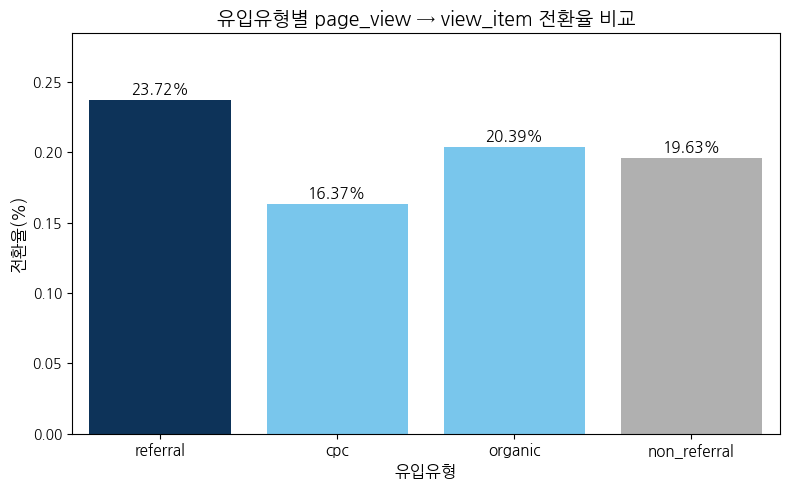

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.barplot(
    data=summary_all,
    x='유입유형',
    y='전환율',
    palette=[color_map.get(x, '#999999') for x in summary_all['유입유형']]
)

plt.title('유입유형별 page_view → view_item 전환율 비교', fontsize=14, weight='bold')
plt.ylabel('전환율(%)', fontsize=12)
plt.xlabel('유입유형', fontsize=12, fontweight='bold')

# 막대 위에 전환율 표시
for i, v in enumerate(summary_all['전환율']):
    plt.text(i, v + 0.002, f"{v:.2%}", ha='center', va='bottom', fontsize=11, weight='bold')

plt.xticks(fontsize=11, fontweight='bold')
plt.ylim(0, summary_all['전환율'].max() * 1.2)
plt.tight_layout()
plt.show()

* referral이 23.48%, non_referral이 20.27%로 referral을 통해 유입된 경우가 전환율이 약 3% 정도 높게 나타남을 확인할 수 있다.
* 광고를 통한 cpc의 전환율이 18.79%로 referral로 유입된 경우가 cpc보다 약 5% 높다는 것을 확인할 수 있다

### 가설2 : 체류시간이 길어질수록 상품보기의 전환율이 높아질 것이다

**a. 통계검증**

In [ ]:
# 필요한 컬럼만 추가
cols_need = ['사용자ID','세션_식별자','타입','이벤트발생시간']

df2 = (
    store[cols_need]
    .dropna(subset=['사용자ID','세션_식별자','타입','이벤트발생시간'])
    .copy()
)

# 이벤트 시간 변환
df2['이벤트발생시간'] = pd.to_datetime(df2['이벤트발생시간'], errors='coerce')
df2 = df2.dropna(subset=['이벤트발생시간']).copy()

In [ ]:
# 세션별 체류시간(초) 계산
session_span = (
    df2.groupby(['사용자ID','세션_식별자'], observed=True)['이벤트발생시간']
       .agg(['min','max'])
       .reset_index()
)
session_span['체류시간(초)'] = (session_span['max'] - session_span['min']).dt.total_seconds()
session_span['체류시간(초)'] = session_span['체류시간(초)'].clip(lower=0)

# 극단값(99%) 확인
p99 = session_span['체류시간(초)'].quantile(0.99)

# 방문 세션/ 상품보기 세션 구분
visit_df = (
    df2[df2['타입'].isin(['session_start','page_view'])]
      [['사용자ID','세션_식별자']].drop_duplicates()
)
view_df = (
    df2[df2['타입'].eq('view_item')]
      [['사용자ID','세션_식별자']].drop_duplicates()
)

In [ ]:
# 전환여부(0/1) + 체류시간 결합
merged = (
    visit_df.merge(view_df, on=['사용자ID','세션_식별자'], how='left', indicator=True)
            .merge(session_span[['사용자ID','세션_식별자','체류시간(초)']],
                   on=['사용자ID','세션_식별자'], how='left')
            .dropna(subset=['체류시간(초)'])
            .copy()
)
merged['전환여부'] = np.where(merged['_merge'] == 'both', 1, 0)
merged.drop(columns=['_merge'], inplace=True)
merged['log_체류시간'] = np.log1p(merged['체류시간(초)'])

In [ ]:
# 전환여부별 체류시간 요약 통계
summary_stats = (
    merged.groupby('전환여부')['체류시간(초)']
    .describe(percentiles=[0.25, 0.5, 0.75])  # 사분위 포함
    .rename(index={0:'비전환(방문만)', 1:'전환(상품보기발생)'})
    [['count','mean','min','25%','50%','75%','max']]
    .round(2)
)

summary_stats.columns = ['표본수','평균','최소','1사분위(Q1)','중앙값(Q2)','3사분위(Q3)','최대']

print("📊 전환여부별 체류시간 요약 통계 (초 단위):")
display(summary_stats)

📊 전환여부별 체류시간 요약 통계 (초 단위):


,표본수,평균,최소,1사분위(Q1),중앙값(Q2),3사분위(Q3),최대
전환여부,,,,,,,
비전환(방문만),18566.0,99.25,0.0,3.0,7.0,34.00,24139.0
전환(상품보기발생),4616.0,530.41,0.0,47.0,198.0,661.25,42994.0


In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu

converted = merged.loc[merged['전환여부']==1, '체류시간(초)'].values
nonconv  = merged.loc[merged['전환여부']==0, '체류시간(초)'].values

# Welch t-test (평균 차이)
t_stat, t_p = ttest_ind(converted, nonconv, equal_var=False, nan_policy='omit')

# Mann-Whitney U (중앙값 기반)
u_stat, u_p = mannwhitneyu(converted, nonconv, alternative='two-sided')

# Cohen’s d (효과 크기)
def cohens_d(a, b):
    na, nb = len(a), len(b)
    va, vb = np.var(a, ddof=1), np.var(b, ddof=1)
    s_pool = np.sqrt(((na-1)*va + (nb-1)*vb) / (na+nb-2))
    return (np.mean(a) - np.mean(b)) / s_pool

d = cohens_d(converted, nonconv)

# Rank-biserial 상관
n1, n0 = len(converted), len(nonconv)
rank_biserial = 1 - 2*u_stat/(n1*n0)

In [ ]:
# 결과 확인

print("통계 검정 결과")
print(f" - Welch t-test: t={t_stat:.3f}, p={t_p:.6f}")
print(f" - Mann-Whitney U: U={u_stat:.0f}, p={u_p:.6f}")
print(f" - Cohen's d: {d:.3f} (0.2=small, 0.5=medium, 0.8=large)")
print(f" - Rank-biserial: {rank_biserial:.3f} (-1~1)\n")

# 평균 비교 코멘트
mean_conv, mean_nonconv = np.mean(converted), np.mean(nonconv)
direction = "전환 세션 > 비전환 세션" if mean_conv > mean_nonconv else "전환 세션 ≤ 비전환 세션"
print(f"평균 비교: 전환 {mean_conv:,.2f}초 vs 비전환 {mean_nonconv:,.2f}초 → {direction}\n")

통계 검정 결과
 - Welch t-test: t=27.479, p=0.000000
 - Mann-Whitney U: U=70435829, p=0.000000
 - Cohen's d: 0.747 (0.2=small, 0.5=medium, 0.8=large)
 - Rank-biserial: -0.644 (-1~1)

평균 비교: 전환 530.41초 vs 비전환 99.25초 → 전환 세션 > 비전환 세션



* 상품보기를 한 세션은, 그렇지 않은 세션보다 평균적으로 훨씬 더 오래 머물렀으며, 이 차이는 통계적으로도 매우 유의하고, 실제로도 큰 효과 크기를 가진다

**b. 시각화**

/tmp/ipython-input-791917771.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




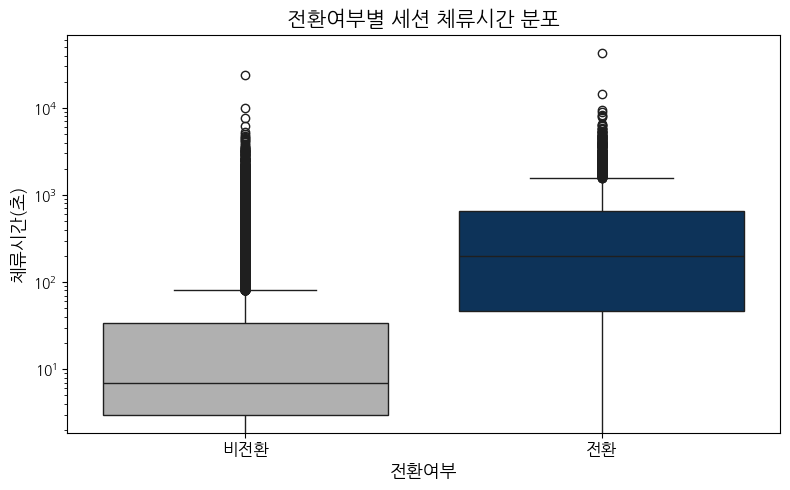

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=merged, x='전환여부', y='체류시간(초)', palette=['#B0B0B0', '#003366'])

plt.yscale('log')
plt.xlabel("전환여부", fontsize=13, fontweight='bold')
plt.ylabel("체류시간(초)", fontsize=13, fontweight='bold')
plt.xticks([0,1], ['비전환', '전환'], fontsize=12, fontweight='bold')
plt.title('전환여부별 세션 체류시간 분포', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()


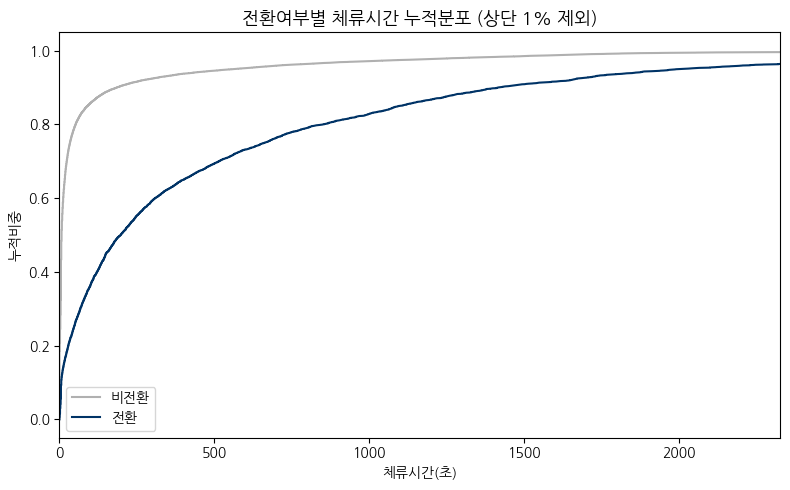

In [ ]:
# 누적분포(CDF)
plt.figure(figsize=(8,5))
for flag, label, color in [(0,'비전환','#B0B0B0'), (1,'전환','#003366')]:
    x = np.sort(merged.loc[merged['전환여부']==flag, '체류시간(초)'])
    y = np.linspace(0,1,len(x))
    plt.plot(x, y, label=label, color=color)
plt.xlim(0, p99)
plt.xlabel('체류시간(초)', fontweight='bold')
plt.ylabel('누적비중', fontweight='bold')
plt.title('전환여부별 체류시간 누적분포 (상단 1% 제외)', fontsize=13, weight='bold')
plt.legend()
plt.tight_layout()
plt.show()

* 전환의 경우가 비전환의 경우보다 체류시간이 길다는 것을 확인할 수 있다
* 비전환의 경우에는 전환의 경우와 달리 초반에 이탈하는 비중이 높다는 것을 알 수 있다

In [ ]:
# 비전환 세션 추출하여, 체류시간(초)을 x축으로 한 히스토그램 확인 (범위 : 최소 ~ 3사분위)

# 비전환 데이터 추출
nonconv_df = merged[merged['전환여부'] == 0].copy()

# 주요 통계값 계산
min_val = nonconv_df['체류시간(초)'].min()
q1 = nonconv_df['체류시간(초)'].quantile(0.25)
median = nonconv_df['체류시간(초)'].median()
q3 = nonconv_df['체류시간(초)'].quantile(0.75)

print(f"비전환 세션 체류시간 요약 (초)")
print(f"최소: {min_val:.2f}초 | 1사분위(Q1): {q1:.2f}초 | 중앙값(Q2): {median:.2f}초 | 3사분위(Q3): {q3:.2f}초")


비전환 세션 체류시간 요약 (초)
최소: 0.00초 | 1사분위(Q1): 3.00초 | 중앙값(Q2): 7.00초 | 3사분위(Q3): 34.00초


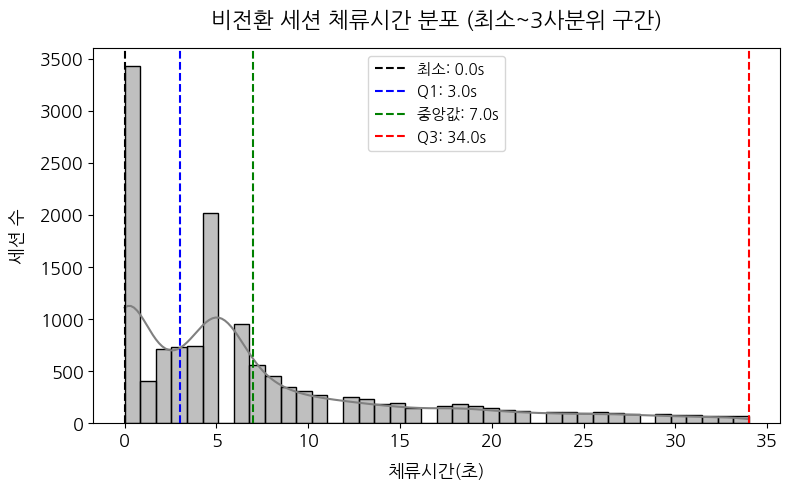

In [ ]:
# 히스토그램
plt.figure(figsize=(8,5))
sns.histplot(
    data=nonconv_df[nonconv_df['체류시간(초)'] <= q3],
    x='체류시간(초)', bins=40, color='gray', kde=True
)

plt.title('비전환 세션 체류시간 분포 (최소~3사분위 구간)', fontsize=16, weight='bold', pad=15)
plt.xlabel('체류시간(초)', fontsize=13, weight='bold', labelpad=10)
plt.ylabel('세션 수', fontsize=13, weight='bold', labelpad=10)

plt.xticks(fontsize=13, weight='bold')
plt.yticks(fontsize=13, weight='bold')

# 주요 구간선 표시
plt.axvline(min_val, color='black', linestyle='--', label=f'최소: {min_val:.1f}s')
plt.axvline(q1, color='blue', linestyle='--', label=f'Q1: {q1:.1f}s')
plt.axvline(median, color='green', linestyle='--', label=f'중앙값: {median:.1f}s')
plt.axvline(q3, color='red', linestyle='--', label=f'Q3: {q3:.1f}s')

plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


* 페이지에 진입하자마자 이탈한 세션(0초)이 35000건 이상으로, 전체의 17.5%를 차지하며, 7초에 50%가 존재하고, 이 후 체류 시간별, 세션이 고르게 퍼지게 되어 34초에서 75%가 존재한다

##  2순위 : 장바구니 담기 -> 결제

### 가설3 : 장바구니에 상품이 담긴 시간을 기준으로, 24시간 이내 구매 전환율이 50%보다 높다

**a.통계검증**

In [ ]:
# 필요한 컬럼만 추출
cols_need = ['사용자ID','세션_식별자','상품ID','타입','이벤트발생시간']
df3 = store[cols_need].dropna(subset=['사용자ID','상품ID','타입','이벤트발생시간']).copy()

# 이벤트 시간 변환
df3['이벤트발생시간'] = pd.to_datetime(df3['이벤트발생시간'], errors='coerce')
df3 = df3.dropna(subset=['이벤트발생시간']).copy()

In [ ]:
# 장바구니 -> 구매 연결
cart_time = (
    df3[df3['타입'] == 'add_to_cart']
    .groupby(['사용자ID','상품ID'], as_index=False)['이벤트발생시간']
    .min()
    .rename(columns={'이벤트발생시간':'장바구니_시간'})
)

purchase_time = (
    df3[df3['타입'] == 'purchase']
    .groupby(['사용자ID','상품ID'], as_index=False)['이벤트발생시간']
    .min()
    .rename(columns={'이벤트발생시간':'구매_시간'})
)

In [ ]:
# 병합
merged_cart = pd.merge(cart_time, purchase_time, on=['사용자ID','상품ID'], how='left')

# 구매까지 소요시간 계산 (초)
merged_cart['소요시간(초)'] = (merged_cart['구매_시간'] - merged_cart['장바구니_시간']).dt.total_seconds()
merged_cart['소요시간(초)'] = merged_cart['소요시간(초)'].fillna(np.inf)  # 미구매 → ∞

In [ ]:
# 24시간 이내 구매 여부 계산
merged_cart['within_24h'] = np.where(merged_cart['소요시간(초)'] <= 86400, 1, 0)
merged_cart['구매여부'] = np.where(np.isfinite(merged_cart['소요시간(초)']), 1, 0)

# 구매한 사용자만 필터링
buyers = merged_cart[merged_cart['구매여부'] == 1].copy()



In [ ]:
# 단일표본 Z-test (24시간 내 전환율이 0.5보다 높은가)

count = buyers['within_24h'].sum()
nobs = len(buyers)
value = 0.5

z_stat, p_val = proportions_ztest(count, nobs, value, alternative='larger')

print("📈 [단일표본 Z-test: 24시간 내 구매 전환율 > 50% ?]")
print(f"Z-statistic = {z_stat:.3f}, p-value = {p_val:.5f}")
print(f"24시간 내 구매 비율 = {count/nobs:.2%}  (n={nobs:,})")

if p_val < 0.05:
    print("24시간 내 구매 전환율이 50%보다 통계적으로 유의하게 높음 (p < 0.05)")
else:
    print("유의한 차이 없음 (p ≥ 0.05)")

📈 [단일표본 Z-test: 24시간 내 구매 전환율 > 50% ?]
Z-statistic = 24.699, p-value = 0.00000
24시간 내 구매 비율 = 91.89%  (n=259)
24시간 내 구매 전환율이 50%보다 통계적으로 유의하게 높음 (p < 0.05)


**b. 시각화**

24시간 기준 구매 전환 비율

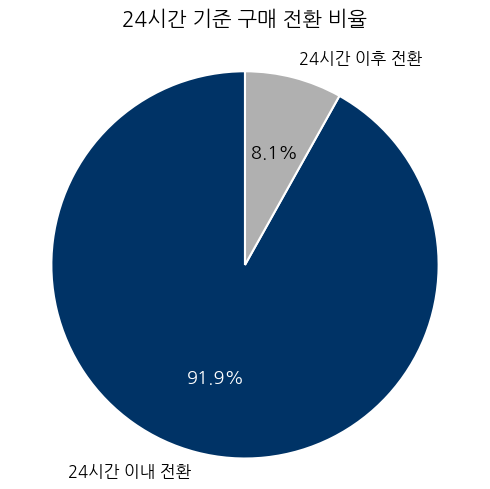

In [ ]:
# 시각화

summary = (
    buyers['within_24h']
    .value_counts(normalize=True)
    .rename({1:'24시간 이내 전환', 0:'24시간 이후 전환'})
    .rename_axis('전환구간')
    .reset_index(name='비율')
)

# 색상 팔레트
colors = ['#003366', '#B0B0B0']

#  autopct 함수
def make_autopct():
    def my_autopct(pct):
        color = 'white' if pct > 50 else 'black'
        return f"{pct:.1f}%"
    return my_autopct

# 파이차트
plt.figure(figsize=(5,5))
wedges, texts, autotexts = plt.pie(
    summary['비율'],
    labels=summary['전환구간'],
    autopct=make_autopct(),
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12, 'weight': 'bold', 'color': 'black'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

# 비율 글씨 색상 조정
for i, autotext in enumerate(autotexts):
    autotext.set_color('white' if summary['전환구간'][i] == '24시간 이내 전환' else 'black')
    autotext.set_fontsize(13)
    autotext.set_weight('bold')


plt.title('24시간 기준 구매 전환 비율', fontsize=15, weight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()



24시간 이내 전환한 구매자들에 대한 누적 전환율

In [ ]:
# 필요한 이벤트만 필터링
df_tmp = store[store['타입'].isin(['add_to_cart', 'purchase'])].copy()
df_tmp['이벤트발생시간'] = pd.to_datetime(df_tmp['이벤트발생시간'], errors='coerce')
df_tmp = df_tmp.dropna(subset=['사용자ID', '상품ID', '이벤트발생시간']).copy()

In [ ]:
# add_to_cart 시점과 purchase 시점 매칭
cart_time = (
    df_tmp[df_tmp['타입'] == 'add_to_cart']
    .groupby(['사용자ID','상품ID'], as_index=False)['이벤트발생시간']
    .min()
    .rename(columns={'이벤트발생시간':'cart_time'})
)

purchase_time = (
    df_tmp[df_tmp['타입'] == 'purchase']
    .groupby(['사용자ID','상품ID'], as_index=False)['이벤트발생시간']
    .min()
    .rename(columns={'이벤트발생시간':'purchase_time'})
)

# 병합
merged_cart = pd.merge(cart_time, purchase_time, on=['사용자ID','상품ID'], how='left')

In [ ]:
# 장바구니 → 구매까지 걸린 시간 계산 (초)
merged_cart['소요시간(초)'] = (merged_cart['purchase_time'] - merged_cart['cart_time']).dt.total_seconds()
merged_cart['소요시간(초)'] = merged_cart['소요시간(초)'].fillna(np.inf)  # 미구매 → ∞

In [ ]:
# 24시간 이내 구매만 필터링 후 CDF 계산
conv_cart = merged_cart[np.isfinite(merged_cart['소요시간(초)'])].copy()
conv_cart = conv_cart[conv_cart['소요시간(초)'] <= 86400]
conv_cart['소요시간(시간)'] = (conv_cart['소요시간(초)'] / 3600).round(2)

conv_cart = conv_cart.sort_values('소요시간(시간)')
conv_cart['누적비율'] = np.arange(1, len(conv_cart)+1) / len(conv_cart)

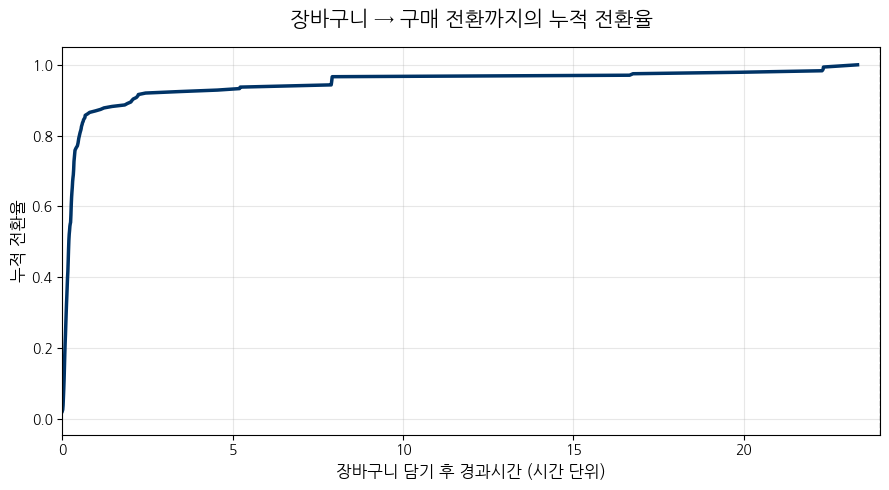

In [ ]:
# 시각화
plt.figure(figsize=(9,5))
sns.lineplot(
    x='소요시간(시간)',
    y='누적비율',
    data=conv_cart,
    color='#003366',
    linewidth=2.5
)
plt.axvline(24, color='gray', linestyle='--', lw=1)

plt.title("장바구니 → 구매 전환까지의 누적 전환율", fontsize=15, weight='bold', pad=15)
plt.xlabel("장바구니 담기 후 경과시간 (시간 단위)", fontsize=12)
plt.ylabel("누적 전환율", fontsize=12)
plt.xlim(0, 24)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 가설4 : 서로 다른 날짜에 반복 구매한 재구매자는 하루 동안만 구매한 단일구매자보다 더 다양한 카테고리의 상품을 구매할 것이다.

**a. 통계검증**

상품 카테고리 정보는 캐글에서 제공하는 통합데이터(dataton).csv에만 존재하므로, 본 연구에서는 해당 데이터를 기반으로 분석을 수행하였다.

구매유형
* 단일구매자 - purchase 이벤트가 발생한 날짜가 하루에 해당하는 사용자
* 재구매자 - purchase 이벤트가 서로 다른 날짜에 두 차례 이상 발생한 사용자

In [ ]:
# 캐글 데이터 확인
data_ka = pd.read_csv("/content/통합데이터셋(dataton).csv")
data_ka

,사용자ID,세션_식별자,국가,기기,타입,상품고유번호,이벤트발생시간,누적구매금액,시간,상품ID,상품이름,상품브랜드,옵션,상품카테고리,상품가격
0,2133,16909,US,mobile,purchase,94,2020-11-01 00:27:14,34,2020-11-01 00:09:55,94,Google Large Tote White,Google,Single Option Only,Bags,10
1,2133,16909,US,mobile,purchase,425,2020-11-01 00:27:14,34,2020-11-01 00:09:55,425,Google Heather Green Speckled Tee,Google,XL,Apparel,21
2,5789,16908,SE,desktop,purchase,1,2020-11-01 01:44:44,72,2020-10-14 00:26:03,1,Google KeepCup,Google,Single Option Only,New,28
3,5789,16908,SE,desktop,purchase,62,2020-11-01 01:44:44,72,2020-10-14 00:26:03,62,Google Mini Kick Ball,Google,Single Option Only,Fun,2
4,5808,4267,US,mobile,add_to_cart,842,2020-11-01 03:06:29,0,2020-08-18 03:44:52,842,Google Infant Hero Onesie Grey,Google,NaN,Apparel,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758879,234237,12443,IN,desktop,add_to_cart,1130,2021-01-31 23:59:08,0,2021-01-31 23:56:44,1130,Google Pocket Tee Grey,Google,NaN,Apparel,29
758880,234237,12443,IN,desktop,add_to_cart,973,2021-01-31 23:59:08,0,2021-01-31 23:56:44,973,Android Super Hero 3D Framed Art,Android,NaN,Accessories,40
758881,234237,12443,IN,desktop,add_to_cart,915,2021-01-31 23:59:08,0,2021-01-31 23:56:44,915,Android Large Removable Sticker Sheet,Android,NaN,Accessories,3
758882,234237,12443,IN,desktop,add_to_cart,919,2021-01-31 23:59:08,0,2021-01-31 23:56:44,919,Android SM S/F18 Sticker Sheet,Android,NaN,Accessories,3


In [ ]:
df4 = data_ka.copy()

# 구매 데이터만 필터링
df4 = df4[df4['타입'] == 'purchase'].dropna(subset=['사용자ID', '상품카테고리', '이벤트발생시간']).copy()
df4['이벤트발생시간'] = pd.to_datetime(df4['이벤트발생시간'], errors='coerce')

# 구매일 컬럼 생성
df4['구매일'] = df4['이벤트발생시간'].dt.date

In [ ]:
# 사용자별 구매 요약
user_summary = (
    df4.groupby('사용자ID')
       .agg(
           구매일수=('구매일', 'nunique'),
           총구매상품수=('상품ID', 'nunique'),
           카테고리수=('상품카테고리', 'nunique')
       )
       .reset_index()
)

# 재구매자 단일구매자 분류
user_summary['구매유형'] = np.where(user_summary['구매일수'] > 1, '재구매자', '단일구매자')

In [ ]:
# 통계검정(Welch’s t-test)
group_re = user_summary.loc[user_summary['구매유형'] == '재구매자', '카테고리수']
group_single = user_summary.loc[user_summary['구매유형'] == '단일구매자', '카테고리수']

t_stat, p_val = ttest_ind(group_re, group_single, equal_var=False)

print("📊 [가설3: 날짜 기준 재구매자는 더 다양한 카테고리를 구매한다]")
print(f"T-statistic = {t_stat:.3f}, p-value = {p_val:.5f}")
print(f"재구매자 평균 카테고리 수: {group_re.mean():.3f}")
print(f"단일구매자 평균 카테고리 수: {group_single.mean():.3f}")

if p_val < 0.05 and group_re.mean() > group_single.mean():
    print("재구매자의 카테고리 다양성이 통계적으로 유의하게 높음 (p < 0.05)")
else:
    print("유의한 차이 없음 (p ≥ 0.05)")

📊 [가설3: 날짜 기준 재구매자는 더 다양한 카테고리를 구매한다]
T-statistic = 10.592, p-value = 0.00000
재구매자 평균 카테고리 수: 3.507
단일구매자 평균 카테고리 수: 2.193
재구매자의 카테고리 다양성이 통계적으로 유의하게 높음 (p < 0.05)


* 재구매자는 단일구매자에 비해 더 다양한 상품 카테고리를 구매하는 경향이 있으며,
이는 통계적으로 유의미한 차이로 확인되었다.

**b.시각화**

/tmp/ipython-input-2680387918.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




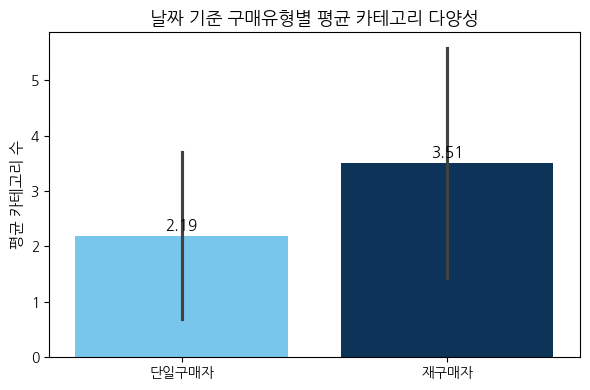

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

sns.barplot(
    data=user_summary,
    x='구매유형', y='카테고리수',
    palette=['#66CCFF', '#003366'],
    errorbar='sd'
)

plt.title('날짜 기준 구매유형별 평균 카테고리 다양성', fontsize=13, weight='bold')
plt.ylabel('평균 카테고리 수', fontsize=11)
plt.xlabel('')

for i, val in enumerate(user_summary.groupby('구매유형')['카테고리수'].mean()):
    plt.text(i, val + 0.1, f"{val:.2f}", ha='center', fontsize=11, weight='bold')

plt.tight_layout()
plt.show()


## 3순위: 상품보기 -> 상품탐색

### 가설5 : 신규 1회 방문자가 다른 사용자 분류보다 탐색 전환율이 낮을 것이다

**a. 통계검증**

In [ ]:
# 필요한 컬럼 필터링
df5 = store.copy()

cols_need = ['사용자ID', '세션_식별자', '타입', '사용자분류']
df5 = df5[cols_need].dropna(subset=['사용자ID', '타입', '사용자분류']).copy()

In [ ]:
# 사용자별 이벤트 발생 여부 집계
user_event_bin = (
    df5.groupby(['사용자ID', '타입'])
       .size()
       .unstack(fill_value=0)
       .reset_index()
)

# view_item / select_item 플래그 생성
user_event_bin['view_flag'] = np.where(user_event_bin.get('view_item', 0) > 0, 1, 0)
user_event_bin['select_flag'] = np.where(user_event_bin.get('select_item', 0) > 0, 1, 0)

# view_item → select_item 탐색 전환 여부
user_event_bin['탐색전환'] = np.where(
    (user_event_bin['view_flag'] == 1) & (user_event_bin['select_flag'] == 1),
    1, 0
)

In [ ]:
# 사용자 유형 병합
merged_bin = pd.merge(
    user_event_bin,
    df5[['사용자ID', '사용자분류']].drop_duplicates(),
    on='사용자ID',
    how='left'
)

In [ ]:
# 그룹별 탐전환율 요약
summary_bin = (
    merged_bin.groupby('사용자분류')['탐색전환']
    .agg(['mean','count'])
    .rename(columns={'mean':'탐색전환율'})
    .round(4)
)
print("\n[이진형] 사용자유형별 탐색전환율 요약:\n", summary_bin)


[이진형] 사용자유형별 탐색전환율 요약:
          탐색전환율  count
사용자분류                
기존유저    0.1715    962
신규1회방문  0.0379  15601
신규재방문   0.2249   1432


In [ ]:
# 통계검정 (Welch’s t-test)

# 신규 1회 방문자
new_single = merged_bin.loc[merged_bin['사용자분류'] == '신규1회방문', '탐색전환']

# 기존유저 + 신규재방문 통합 그룹
existing_group = merged_bin.loc[
    merged_bin['사용자분류'].isin(['기존유저', '신규재방문']),
    '탐색전환'
]

# Welch’s t-test 수행
t_stat, p_val = ttest_ind(new_single, existing_group, equal_var=False)

print(f"\n[T-test] 신규1회방문 vs (기존유저 + 신규재방문): t={t_stat:.3f}, p={p_val:.4f}")
print(f"신규1회방문 평균: {new_single.mean():.4f}")
print(f"기존·재방문 평균: {existing_group.mean():.4f}")

if p_val < 0.05 and new_single.mean() < existing_group.mean():
    print("신규 1회 방문자의 탐색전환율이 기존·재방문 그룹보다 유의하게 낮습니다.")
else:
    print("유의미한 차이가 없거나 반대 방향입니다.")


[T-test] 신규1회방문 vs (기존유저 + 신규재방문): t=-19.771, p=0.0000
신규1회방문 평균: 0.0379
기존·재방문 평균: 0.2034
신규 1회 방문자의 탐색전환율이 기존·재방문 그룹보다 유의하게 낮습니다.


**b.시각화**

/tmp/ipython-input-3945954423.py:9: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/tmp/ipython-input-3945954423.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




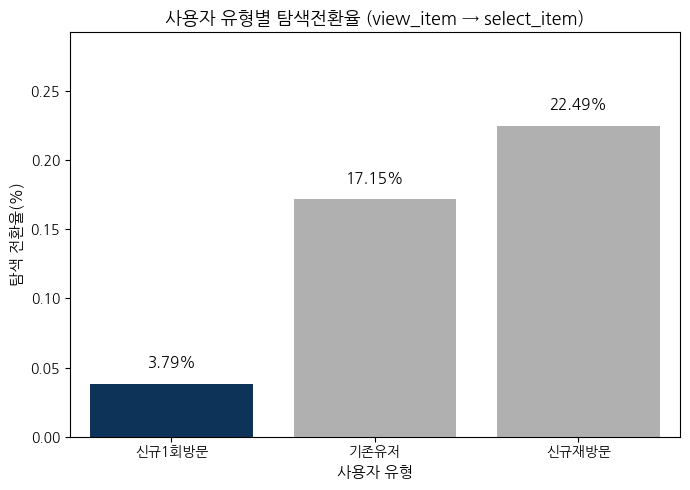

In [ ]:
#시각화

plt.figure(figsize=(7,5))

order = ['신규1회방문', '기존유저', '신규재방문']
palette = ['#003366', '#B0B0B0', '#B0B0B0']

# 막대그래프
ax = sns.barplot(
    data=merged_bin,
    x='사용자분류',
    y='탐색전환',
    order=order,
    estimator=np.mean,
    ci=None,
    palette=palette
)

# 제목 및 축 라벨
plt.title('사용자 유형별 탐색전환율 (view_item → select_item)', fontsize=13, weight='bold')
plt.xlabel('사용자 유형', fontsize=11, weight='bold')
plt.ylabel('탐색 전환율(%)', fontsize=11)

# 막대 위 평균값 표시
group_means = merged_bin.groupby('사용자분류')['탐색전환'].mean().reindex(order)
for i, val in enumerate(group_means):
    plt.text(
        i, val + 0.01, f"{val:.2%}",
        ha='center', va='bottom', fontsize=11, weight='bold'
    )

plt.ylim(0, group_means.max() * 1.3)
plt.tight_layout()
plt.show()


## 4순위 : 상품탐색 -> 장바구니담기

### 가설6: 세션당 상품 탐색 수가 많을수록 장바구니에 담길 확률이 높다

**a.통계검증**

In [ ]:
# 데이터 준비
df6 = store.copy()

# 설정
CONFIG = {
    "col_session": "세션_식별자",
    "col_event": "타입",
    "col_product": "상품ID",
    "explore_events": {"view_item", "product_view", "상품탐색", "상품상세보기"},
    "cart_events": {"add_to_cart", "장바구니담기"},
    "cap_explore_for_plot": 30
}

In [ ]:
# 세션별 파생변수 생성
def build_session_features(df, cfg=CONFIG):
    c_sess, c_evt = cfg["col_session"], cfg["col_event"]
    df = df.copy()

    # 탐색/장바구니 플래그 생성
    df["is_explore"] = df[c_evt].astype(str).isin(cfg["explore_events"]).astype(int)
    df["is_cart"] = df[c_evt].astype(str).isin(cfg["cart_events"]).astype(int)

    # 세션 단위 집계
    session_df = (
        df.groupby(c_sess, as_index=False)
          .agg(
              탐색수=("is_explore", "sum"),
              장바구니여부=("is_cart", "max"),
              총이벤트수=(c_evt, "count")
          )
    )

    session_df["전환여부"] = session_df["장바구니여부"].astype(int)
    return session_df


In [ ]:
# 탐색수 ↔ 전환율 상관관계 요약
def summarize_correlation(session_df):
    corr = session_df["탐색수"].corr(session_df["전환여부"])
    n = len(session_df)
    base_cr = session_df["전환여부"].mean()

    print("[탐색수 vs 전환율 상관요약]")
    print(f"표본 수: {n:,}")
    print(f"전체 전환율: {base_cr:.2%}")
    print(f"피어슨 상관계수 corr(탐색수, 전환여부) = {corr:.4f}")

    pivot = (
        session_df.groupby("탐색수")
                  .agg(세션수=("전환여부", "size"),
                       전환율=("전환여부", "mean"))
                  .reset_index()
                  .sort_values("탐색수")
    )
    display(pivot)
    return pivot

In [ ]:
# 로지스틱 회귀분석
import statsmodels.api as sm

def fit_logit(session_df):
    X = sm.add_constant(session_df["탐색수"])
    y = session_df["전환여부"]
    model = sm.Logit(y, X, missing="drop").fit(disp=0)

    print("\n[로지스틱 회귀 결과]")
    print(model.summary())

    or_val = np.exp(model.params["탐색수"])
    print(f"\n해석: 탐색 1회 증가 시 장바구니 전환 오즈비(OR) ≈ {or_val:.3f}")

    return model

In [ ]:
# 통계 검정 실행
session_df = build_session_features(df6, CONFIG)
pivot = summarize_correlation(session_df)
model = fit_logit(session_df)

[탐색수 vs 전환율 상관요약]
표본 수: 23,121
전체 전환율: 4.88%
피어슨 상관계수 corr(탐색수, 전환여부) = 0.5211


,탐색수,세션수,전환율
0,0,18509,0.000000
1,1,1005,0.010945
2,2,147,0.040816
3,3,57,0.052632
4,4,28,0.107143
...,...,...,...
277,650,1,1.000000
278,751,2,1.000000
279,916,1,1.000000
280,937,1,1.000000



[로지스틱 회귀 결과]
                           Logit Regression Results                           
Dep. Variable:                   전환여부   No. Observations:                23121
Model:                          Logit   Df Residuals:                    23119
Method:                           MLE   Df Model:                            1
Date:                Mon, 17 Nov 2025   Pseudo R-squ.:                  0.3303
Time:                        06:55:09   Log-Likelihood:                -3020.1
converged:                       True   LL-Null:                       -4509.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7956      0.045    -85.142      0.000      -3.883      -3.708
탐색수            0.0437      0.001     40.030      0.000       0.042       0.046

해석: 탐색 1회 증가 시 장바구니 전환 오즈비(OR) ≈ 1.04

* 분석결과, 상품 탐색 수가 증가할수록 장바구니 전환 확률이 통계적으로 유의하게 상승하였다

**b.시각화**

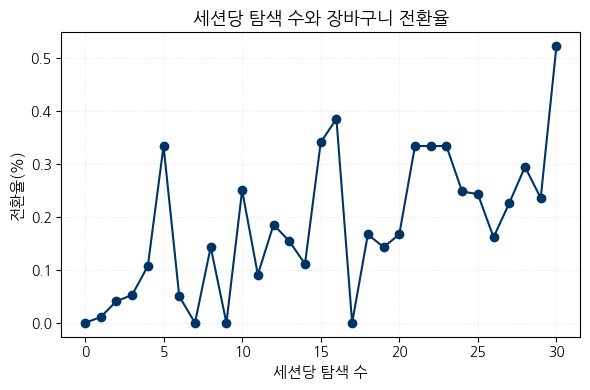

In [ ]:
# 시각화
def plot_conversion_curve(session_df, cap=CONFIG["cap_explore_for_plot"]):
    df_plot = session_df.copy()
    df_plot["탐색수_cap"] = np.where(df_plot["탐색수"] > cap, cap, df_plot["탐색수"])

    curve = (
        df_plot.groupby("탐색수_cap")
               .agg(세션수=("전환여부", "size"),
                    전환율=("전환여부", "mean"))
               .reset_index()
               .rename(columns={"탐색수_cap": "탐색수"})
    )

    plt.figure(figsize=(6,4))
    plt.plot(curve["탐색수"], curve["전환율"], marker='o', color='#003366')
    plt.title("세션당 탐색 수와 장바구니 전환율", fontsize=13, weight='bold')
    plt.xlabel("세션당 탐색 수", fontsize=11)
    plt.ylabel("전환율(%)", fontsize=11)
    plt.grid(alpha=0.3, linestyle=':')
    plt.tight_layout()
    plt.show()

    return curve

# 실행결과
curve = plot_conversion_curve(session_df)

*  탐색 수가 많아질수록, 전환율이 상승하는 추세를 보이며, 14회를 기준으로 전환율이 크게 오르게 된다

### 가설7 : 유저타입에 따라 장바구니 전환율이 다를 것이다

**a.통계검증**

In [ ]:
df7 = store.copy()

# 단계별 이벤트 플래그 생성
user_events = (
    df7.groupby(['사용자ID', '타입'])
        .size()
        .unstack(fill_value=0)
        .reset_index()
)

# 각 단계별 플래그 (있으면 1, 없으면 0)
user_events['page_flag'] = np.where(user_events.get('page_view', 0) > 0, 1, 0)
user_events['view_flag'] = np.where(user_events.get('view_item', 0) > 0, 1, 0)
user_events['select_flag'] = np.where(user_events.get('select_item', 0) > 0, 1, 0)
user_events['cart_flag'] = np.where(user_events.get('add_to_cart', 0) > 0, 1, 0)
user_events['purchase_flag'] = np.where(user_events.get('purchase', 0) > 0, 1, 0)

In [ ]:
# 이전 방문 단게를 거친 사용자만 필터링
valid_users = user_events[
    (user_events['page_flag'] == 1) &
    (user_events['view_flag'] == 1) &
    (user_events['select_flag'] == 1)
].copy()

In [ ]:
# view_item -> add_to_cart 전환 플래그 계산
valid_users['view→cart_전환'] = np.where(
    (valid_users['view_flag'] == 1) & (valid_users['cart_flag'] == 1), 1, 0
)


In [ ]:
# 사용자분류 병합
merged = pd.merge(
    df7[['사용자ID', '사용자분류']].drop_duplicates(),
    valid_users[['사용자ID', 'view→cart_전환']],
    on='사용자ID',
    how='inner'
)

In [ ]:
# 사용자유형별 전환율 요약
conversion_summary = (
    merged.groupby('사용자분류')['view→cart_전환']
          .agg(['mean', 'count'])
          .rename(columns={'mean': '전환율', 'count': '유효사용자수'})
          .reset_index()
)
print("📊 [사용자유형별 view_item → add_to_cart 전환율 요약 (모든 이전 단계 완료 사용자 기준)]\n")
display(conversion_summary)

📊 [사용자유형별 view_item → add_to_cart 전환율 요약 (모든 이전 단계 완료 사용자 기준)]



,사용자분류,전환율,유효사용자수
0,기존유저,0.406061,165
1,신규1회방문,0.290541,592
2,신규재방문,0.496894,322


In [ ]:
# 카이제곱 독립성 검정

from scipy.stats import chi2_contingency
contingency = pd.crosstab(merged['사용자분류'], merged['view→cart_전환'])
chi2, p, dof, expected = chi2_contingency(contingency)

print("[카이제곱 독립성 검정 결과]")
print(f"Chi2 통계량: {chi2:.3f}")
print(f"p-value: {p:.5f}")
print(f"자유도: {dof}")
if p < 0.05:
    print("사용자 유형에 따라 전환율에 유의한 차이가 있음 (p < 0.05)")
else:
    print("유의미한 차이가 없음 (p ≥ 0.05)")

[카이제곱 독립성 검정 결과]
Chi2 통계량: 39.208
p-value: 0.00000
자유도: 2
사용자 유형에 따라 전환율에 유의한 차이가 있음 (p < 0.05)


* 사용자의 유형에 따라, 장바구니 담기의 차이가 유의한 결과를 가져온다

**b.시각화**

/tmp/ipython-input-3040706000.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




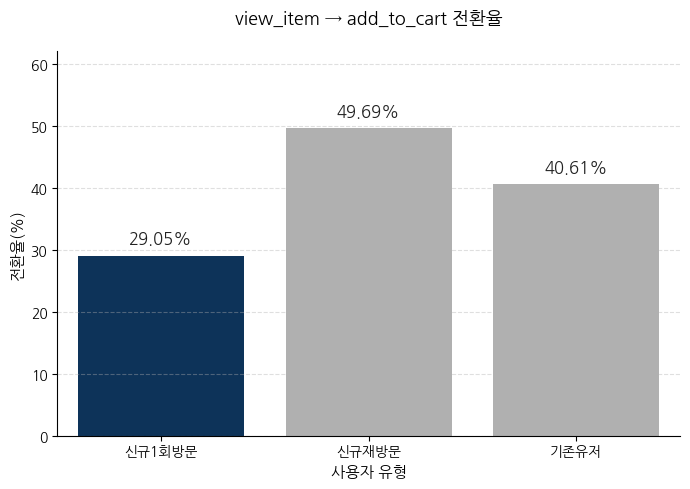

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 전환율을 %로 변환
conversion_summary['전환율(%)'] = conversion_summary['전환율'] * 100

# 표시 순서 지정
order = ['신규1회방문', '신규재방문', '기존유저']
conversion_summary = conversion_summary.set_index('사용자분류').loc[order].reset_index()

# 색상 지정
colors = ['#003366' if cat == '신규1회방문' else '#B0B0B0' for cat in conversion_summary['사용자분류']]

plt.figure(figsize=(7,5))
bars = sns.barplot(
    data=conversion_summary,
    x='사용자분류', y='전환율(%)',
    palette=colors
)

plt.ylim(0, conversion_summary['전환율(%)'].max() * 1.25)

for bar, val in zip(bars.patches, conversion_summary['전환율(%)']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(x, y + (conversion_summary['전환율(%)'].max() * 0.03),
             f"{val:.2f}%", ha='center', va='bottom',
             fontsize=12, fontweight='bold', color='#222222')

plt.title("view_item → add_to_cart 전환율",
          fontsize=13, weight='bold', pad=20)
plt.xlabel("사용자 유형", fontsize=11, weight='bold')
plt.ylabel("전환율(%)", fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

# 6. 머신러닝

## 6-1. 머신러닝 방법 설명

상품에 대한 정보가 더 많이 나타나있는, kaggle의 데이터를 사용하였다

사용자의 세션(방문 단위) 데이터로, 구매(purchase) 전환 여부를 예측하는 모델을 구축

방법으로는 구매와 미구매라는 데이터 불균형의 문제를 해결하기 위해 K-means 기반 언더샘플링 기법 활용

## 6-2. 모델 채택

[모델 채택 기준]
* 구매에 대한 데이터가 불균형으로 적기 때문에, 구매에 대한 Accuracy 결과를 기준으로 모델 채택

| 모델                  |  F1-score  |  Accuracy  |
| :------------------ | :--------: | :--------: |
| Logistic Regression |   0.5349   |   0.6699   |
| XGBoost             | 0.7713 |   0.8593   |
| LightGBM            |   0.7605   |   0.8568   |
| Random Forest       |   0.7658   |   0.8603   |
| **CatBoost**            | **0.7713** | **0.8629** |


* 정확도가 0.8629로 가장 높게 나타난 **CatBoost** 모델 채택

## 6-3. CatBoost를 이용한 머신러닝 진행

catboost 설치

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00


In [ ]:
# 라이브러리
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score, f1_score,
                             balanced_accuracy_score, accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool
import shap
import matplotlib.pyplot as plt

In [ ]:
# 데이터 로드
df_ml = data_ka.copy()

# 이벤트 시간 처리
df_ml['이벤트발생시간'] = pd.to_datetime(df_ml['이벤트발생시간'], errors='coerce')
df_ml = df_ml[df_ml['타입'].isin(['add_to_cart','purchase'])].copy()

In [ ]:
# 세션 단위 요약 + 타깃 생성
session = (
    df_ml.groupby(['사용자ID','세션_식별자'])
      .agg(
          상품수=('상품ID','nunique'),
          평균가격=('상품가격','mean'),
          상품카테고리수=('상품카테고리','nunique'),
          기기=('기기','first'),
          국가=('국가','first'),
          첫이벤트시간=('이벤트발생시간','min'),
          마지막이벤트시간=('이벤트발생시간','max'),
          구매여부=('타입', lambda x: int('purchase' in x.values))
      )
      .reset_index()
)

In [ ]:
# 세션 파생 변수
session['세션길이_sec'] = (session['마지막이벤트시간'] - session['첫이벤트시간']).dt.total_seconds().fillna(0)
session['세션길이_min'] = session['세션길이_sec'] / 60
session['요일'] = session['첫이벤트시간'].dt.day_name()
session['시간대'] = session['첫이벤트시간'].dt.hour
session['주말여부'] = session['첫이벤트시간'].dt.dayofweek >= 5
session['이전구매횟수'] = session.groupby('사용자ID')['구매여부'].cumsum() - session['구매여부']
session['카테고리_집중도'] = session['상품수'] / (session['상품카테고리수'] + 1e-5)


In [ ]:
# feature/target 정의
num_cols = ['상품수','평균가격','상품카테고리수','카테고리_집중도','시간대',
            '세션길이_min','이전구매횟수']
cat_cols = ['기기','국가','요일','주말여부']

X = session[num_cols + cat_cols].copy()
y = session['구매여부'].astype(int)

In [ ]:
# train/test 분리
RANDOM_STATE = 42
TEST_SIZE = 0.3
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

In [ ]:
# 언더샘플링(KMeans 사용)
USE_CLUSTER_UNDER = True
UNDER_RATIO = 1.0

def make_ohe():
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown='ignore', sparse=False)

if USE_CLUSTER_UNDER:
    vc = y_train.value_counts()
    minority, majority = vc.idxmin(), vc.idxmax()
    n_min = int(vc.min())
    n_maj_target = int(max(1, n_min * UNDER_RATIO))

    idx_min = y_train[y_train == minority].index
    idx_maj = y_train[y_train == majority].index

    cluster_pp = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', make_ohe(), cat_cols)
    ], sparse_threshold=0.0)

    X_train_all = cluster_pp.fit_transform(X_train)
    Xmaj = X_train_all[X_train.index.get_indexer(idx_maj)]

    kmeans = KMeans(n_clusters=n_maj_target, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(Xmaj)
    centers = kmeans.cluster_centers_

    idx_maj_down = []
    for k in range(n_maj_target):
        mask = (labels == k)
        if not np.any(mask):
            continue
        Xm = Xmaj[mask]
        nearest = np.argmin(((Xm - centers[k])**2).sum(axis=1))
        picked = np.array(idx_maj)[np.where(mask)[0][nearest]]
        idx_maj_down.append(picked)

    idx_under = np.concatenate([np.array(idx_min), np.array(idx_maj_down)])
    X_train_use = X_train.loc[idx_under]
    y_train_use = y_train.loc[idx_under]
    class_weights = None
    print("Class dist (train) Before:", vc.to_dict())
    print("Class dist (train) After :", y_train_use.value_counts().to_dict())
else:
    X_train_use, y_train_use = X_train, y_train
    p = y_train_use.mean()
    class_weights = [1.0, float((1-p)/max(p,1e-9))]


Class dist (train) Before: {0: 8830, 1: 3112}
Class dist (train) After : {1: 3112, 0: 3112}


In [ ]:
# CatBoost Pool 생성
def prepare_catboost_frames(Xtr, Xte, cat_cols):
    Xtr = Xtr.copy(); Xte = Xte.copy()
    for c in cat_cols:
        Xtr[c] = Xtr[c].astype("string").fillna("NA")
        Xte[c] = Xte[c].astype("string").fillna("NA")
    cat_idx = [Xtr.columns.get_loc(c) for c in cat_cols]
    return Xtr, Xte, cat_idx

X_train_cb, X_test_cb, cat_idx = prepare_catboost_frames(X_train_use, X_test, cat_cols)
train_pool = Pool(X_train_cb, y_train_use, cat_features=cat_idx)
test_pool  = Pool(X_test_cb,  y_test,     cat_features=cat_idx)


In [ ]:
# CatBoost 학습
model = CatBoostClassifier(
    depth=6, learning_rate=0.05, iterations=5000,
    loss_function='Logloss', eval_metric='AUC',
    random_seed=RANDOM_STATE, class_weights=class_weights,
    od_type='Iter', od_wait=200, verbose=200
)
model.fit(train_pool, eval_set=test_pool)

0:	test: 0.8887903	best: 0.8887903 (0)	total: 83.9ms	remaining: 6m 59s
200:	test: 0.9427514	best: 0.9429057 (188)	total: 4.85s	remaining: 1m 55s
400:	test: 0.9438960	best: 0.9441253 (348)	total: 7.38s	remaining: 1m 24s
600:	test: 0.9433679	best: 0.9443441 (453)	total: 9.88s	remaining: 1m 12s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9443441423
bestIteration = 453

Shrink model to first 454 iterations.


In [ ]:
# 평가
y_proba = model.predict_proba(test_pool)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print(f"AUC         : {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR-AUC      : {average_precision_score(y_test, y_proba):.4f}")
print(f"ACC         : {accuracy_score(y_test, y_pred):.4f}")
print(f"BAL_ACC     : {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"F1          : {f1_score(y_test, y_pred):.4f}")
print("\nReport\n", classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix\n", confusion_matrix(y_test, y_pred))

AUC         : 0.9443
PR-AUC      : 0.8464
ACC         : 0.8629
BAL_ACC     : 0.8709
F1          : 0.7713

Report
               precision    recall  f1-score   support

           0     0.9557    0.8542    0.9021      3785
           1     0.6820    0.8876    0.7713      1334

    accuracy                         0.8629      5119
   macro avg     0.8188    0.8709    0.8367      5119
weighted avg     0.8844    0.8629    0.8680      5119

Confusion Matrix
 [[3233  552]
 [ 150 1184]]


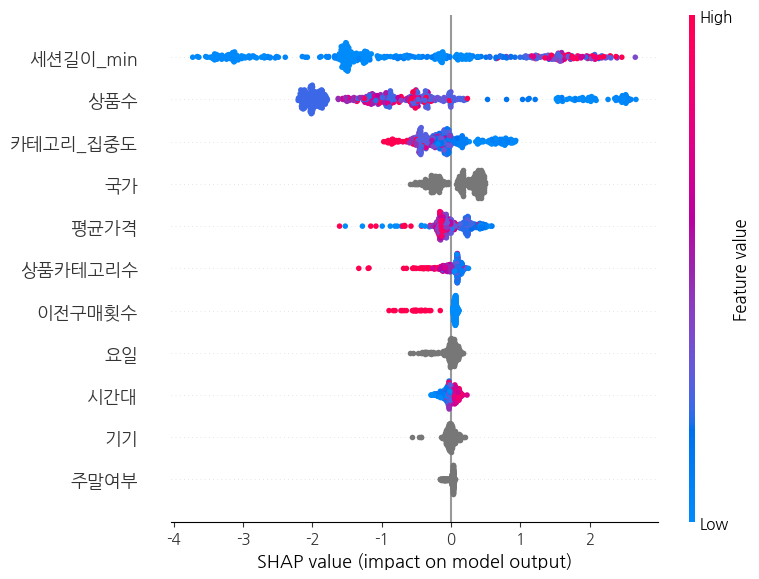

In [ ]:
# SHAP 분석
shap_vals_full = model.get_feature_importance(test_pool, type='ShapValues')
shap_vals = shap_vals_full[:, :-1]

# 샘플링
N = min(500, shap_vals.shape[0])
idx = np.random.RandomState(42).choice(shap_vals.shape[0], N, replace=False)
X_plot = X_test_cb.iloc[idx].copy()
SV_plot = shap_vals[idx]

shap.initjs()
shap.summary_plot(SV_plot, X_plot, feature_names=X_plot.columns, show=True)

In [ ]:
# 세션길이(min) 구간화
session_len = session.copy()
session_len['세션길이_min_int'] = session_len['세션길이_min'].astype(int)

# 전환율 계산 가능한 구간만 사용
conv_time = (
    session_len.groupby('세션길이_min_int')
           .agg(구매전환율=('구매여부','mean'))
           .reset_index()
)

conv_time['구매전환율(%)'] = conv_time['구매전환율'] * 100
conv_time = conv_time.sort_values('세션길이_min_int')

max_len = conv_time['세션길이_min_int'].max()

In [ ]:
# n분 증가 시나리오 함수
def get_time_conversion_for_increase(n):
    df = conv_time.copy()
    df['세션길이_sim'] = (df['세션길이_min_int'] + n).clip(upper=max_len)

    df = df.merge(
        conv_time[['세션길이_min_int','구매전환율(%)']],
        left_on='세션길이_sim',
        right_on='세션길이_min_int',
        how='left',
        suffixes=('', f'_sim{n}')
    )
    return df[f'구매전환율(%)_sim{n}'].mean()


In [ ]:
# 증가량 0~5분 평균 전환율 계산
increases = list(range(6))  # 0~5
conv_values = []

for inc in increases:
    if inc == 0:
        conv_values.append(conv_time['구매전환율(%)'].mean())
    else:
        conv_values.append(get_time_conversion_for_increase(inc))

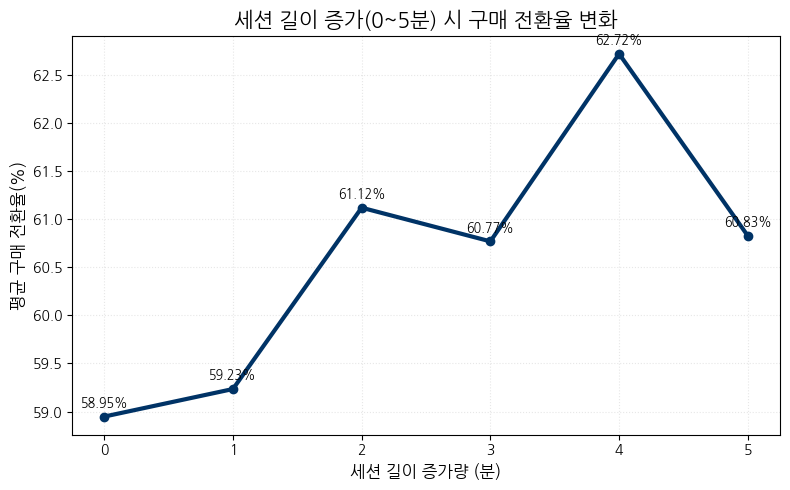

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(increases, conv_values,
         marker='o', linewidth=3, color='#003366')

for x, y in zip(increases, conv_values):
    plt.text(x, y + 0.1, f"{y:.2f}%", ha='center', fontsize=9)

plt.title("세션 길이 증가(0~5분) 시 구매 전환율 변화", fontsize=15)
plt.xlabel("세션 길이 증가량 (분)", fontsize=12)
plt.ylabel("평균 구매 전환율(%)", fontsize=12)
plt.grid(alpha=0.3, linestyle=':')
plt.xticks(increases)

plt.tight_layout()
plt.show()

* 세션의 길이가 증가할수록 평균 구매 전환율이 높아진다

# 7. 딥러닝

**개인 맞춤형 상품 추천 시스템**을 만들기 위해 딥러닝 알고리즘을 사용하였다

## 7-1. 딥러닝 방법 설명

사람이 실제로 클릭하고, 구매한 행동 기록을 기반으로 학습하는 행동 패턴을 학습하는 방식으로, **사용자와 상품 간 관계 패턴**을 학습

사용된 모델 : Two-Tower 모델
* User Tower - 사용자 ID를 입력하여, 사용자의 취향을 표현하는 벡터
* Item Tower - 상품 ID를 입력하여, 상품의 특징을 표현하는 벡터

->  사용자와 상품을 동일한 임베딩 공간(같은 차원)에 위치시키고, 서로 벡터 간 거리를 계산해서 얼마나 잘 맞는지를 평가해내어 추천

## 7-2. 딥러닝 코드 구현

In [ ]:
# =========================================
# 딥러닝 추천시스템: Two-Tower (PyTorch)
#  - Positive: add_to_cart, purchase
#  - Train/Val: 사용자별 최신 1건을 Val
#  - Loss: In-batch NCE (CrossEntropy)
#  - Metrics: Recall@10 (샘플드)
#  - Inference: 사용자별 Top-K 추천 (상품명 포함)
# =========================================


In [ ]:
# 0) 라이브러리
import os, random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

In [ ]:
# 0-1) 재현성 고정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
# 1) 데이터 로드 & 전처리
required_cols = {'사용자ID','상품ID','타입','이벤트발생시간','상품이름'}
missing = required_cols - set(data_ka.columns)
if missing:
    raise ValueError(f"필수 컬럼 누락: {missing}")

df_ml = data_ka.copy()
df_ml['이벤트발생시간'] = pd.to_datetime(df_ml['이벤트발생시간'], errors='coerce')
df_ml = df_ml.dropna(subset=['이벤트발생시간','사용자ID','상품ID','타입'])

# Positive 이벤트만 선택
POS_EVENTS = {'add_to_cart','purchase'}
df_ml = df_ml[df_ml['타입'].isin(POS_EVENTS)].copy()

# 사용자/아이템 인덱싱
uid2idx = {u:i for i,u in enumerate(df_ml['사용자ID'].unique())}
iid2idx = {v:i for i,v in enumerate(df_ml['상품ID'].unique())}
idx2uid = {i:u for u,i in uid2idx.items()}
idx2iid = {i:v for v,i in iid2idx.items()}

df_ml['u'] = df_ml['사용자ID'].map(uid2idx)
df_ml['i'] = df_ml['상품ID'].map(iid2idx)

num_users = len(uid2idx)
num_items = len(iid2idx)
print(f"[INFO] 사용자: {num_users:,}  |  상품: {num_items:,}")

[INFO] 사용자: 13,959  |  상품: 1,363


In [ ]:
# 2) Train / Validation 분리
df_ml = df_ml.sort_values(['u','이벤트발생시간'])
grouped = df_ml.groupby('u')
train_pairs, val_pairs = [], []
for u, sub in grouped:
    items = sub[['i','이벤트발생시간']].values.tolist()
    if len(items) == 1:
        train_pairs.append((u, items[0][0]))
    else:
        for i_idx, _t in items[:-1]:
            train_pairs.append((u, i_idx))
        val_pairs.append((u, items[-1][0]))
train_pairs = np.array(train_pairs, dtype=np.int64)
val_pairs   = np.array(val_pairs,   dtype=np.int64)

# 사용자별 positive 아이템 집합
user_pos_items = defaultdict(set)
for u, i in train_pairs: user_pos_items[u].add(i)
for u, i in val_pairs:   user_pos_items[u].add(i)

print(f"[INFO] train pairs: {len(train_pairs):,}  |  val pairs: {len(val_pairs):,}")

[INFO] train pairs: 669,577  |  val pairs: 13,260


In [ ]:
# 3) DataLoader
class PairDataset(Dataset):
    def __init__(self, pairs): self.pairs = pairs
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        u,i = self.pairs[idx]
        return torch.tensor(u, dtype=torch.long), torch.tensor(i, dtype=torch.long)

BATCH_SIZE = 2048
train_dl = DataLoader(PairDataset(train_pairs),
                      batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
# 4) Two-Tower 모델 정의
class TwoTower(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=64, mlp_hidden=128, dropout=0.1):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)

        self.user_mlp = nn.Sequential(
            nn.Linear(emb_dim, mlp_hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(mlp_hidden, emb_dim)
        )
        self.item_mlp = nn.Sequential(
            nn.Linear(emb_dim, mlp_hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(mlp_hidden, emb_dim)
        )

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
        for m in list(self.user_mlp)+list(self.item_mlp):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def encode_user(self, u_idx):
        ue = self.user_emb(u_idx)
        ue = self.user_mlp(ue)
        return nn.functional.normalize(ue, dim=-1)

    def encode_item(self, i_idx):
        ie = self.item_emb(i_idx)
        ie = self.item_mlp(ie)
        return nn.functional.normalize(ie, dim=-1)

    def forward(self, u_idx, i_idx):
        ue = self.encode_user(u_idx)
        ie = self.encode_item(i_idx)
        return torch.matmul(ue, ie.t())  # [B,B]

In [ ]:
# 5) 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TwoTower(num_users, num_items, emb_dim=64, mlp_hidden=128, dropout=0.1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

EPOCHS = 8
for ep in range(1, EPOCHS+1):
    model.train()
    total = 0.0
    for u,i in train_dl:
        u,i = u.to(device), i.to(device)
        logits = model(u,i)
        labels = torch.arange(logits.size(0), device=device)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item()
    print(f"[Epoch {ep:02d}] train_loss = {total/len(train_dl):.4f}")

[Epoch 01] train_loss = 7.2079
[Epoch 02] train_loss = 7.1059
[Epoch 03] train_loss = 7.0947
[Epoch 04] train_loss = 7.0858
[Epoch 05] train_loss = 7.0816
[Epoch 06] train_loss = 7.0795
[Epoch 07] train_loss = 7.0782
[Epoch 08] train_loss = 7.0772


In [ ]:
# 6) 평가 (샘플드 Recall@10)
@torch.no_grad()
def build_item_matrix(model, batch=4096):
    model.eval()
    embs = []
    for s in range(0, num_items, batch):
        idx = torch.arange(s, min(s+batch, num_items), device=device)
        embs.append(model.encode_item(idx))
    return torch.cat(embs, dim=0)

@torch.no_grad()
def eval_sampled(model, val_pairs, neg_per_user=99, K=10):
    rng = np.random.default_rng(SEED)
    item_mat = build_item_matrix(model)
    hits = []
    for u, pos_i in val_pairs:
        blocked = user_pos_items[u]
        negs=[]
        while len(negs) < neg_per_user:
            n = int(rng.integers(num_items))
            if n not in blocked: negs.append(n)
        candidates = np.array(negs + [pos_i], dtype=np.int64)
        u_emb = model.encode_user(torch.tensor([u], device=device))
        i_emb = item_mat[candidates]
        scores = torch.matmul(u_emb, i_emb.T).squeeze(0).cpu().numpy()
        rank = np.argsort(-scores)
        rank_pos = int(np.where(rank == len(candidates)-1)[0][0])
        hits.append(1 if rank_pos < K else 0)
    recall = float(np.mean(hits))
    print(f"[Eval] Sampled Recall@{K} = {recall:.4f}")
    return recall

_ = eval_sampled(model, val_pairs, neg_per_user=99, K=10)

[Eval] Sampled Recall@10 = 0.7035


In [ ]:
# 7) 추천 (상품 기반 스타일 출력)
item_name_map = (
    df_ml[['상품ID','상품이름']]
    .drop_duplicates()
    .set_index('상품ID')['상품이름']
    .to_dict()
)

@torch.no_grad()
def recommend_for_user(model, user_id, top_k=10, exclude_seen=True):
    """
    특정 사용자(user_id)에 대해 Top-K 추천 상품 출력 (상품 기반 스타일)
    """
    if user_id not in uid2idx:
        print("해당 사용자ID가 학습 데이터에 없음 (cold-start)")
        return None

    model.eval()
    uidx = uid2idx[user_id]
    uvec = model.encode_user(torch.tensor([uidx], device=device))
    item_mat = build_item_matrix(model)
    scores = torch.matmul(uvec, item_mat.T).squeeze(0).cpu().numpy()

    if exclude_seen:
        for i in user_pos_items[uidx]:
            scores[i] = -np.inf

    topk_idx = np.argsort(-scores)[:top_k]
    rec_item_ids = [idx2iid[i] for i in topk_idx]
    rec_item_names = [item_name_map.get(i, "상품명없음") for i in rec_item_ids]

    first_item_id = rec_item_ids[0]
    first_item_name = rec_item_names[0]

    print(f"\n 상품 [{first_item_id}] '{first_item_name}'과(와) 유사한 추천 상품 TOP{top_k}\n")
    print(f"{'순위':>4}  {'상품ID':>6}  {'상품명'}")
    for rank, (pid, pname) in enumerate(zip(rec_item_ids, rec_item_names), 1):
        print(f"{rank:4d}  {pid:6d}  {pname}")

    return pd.DataFrame({
        "순위": np.arange(1, top_k + 1),
        "상품ID": rec_item_ids,
        "상품명": rec_item_names
    })


In [ ]:
# 8) 예시 실행
target_user = list(uid2idx.keys())[0]
recommend_for_user(model, target_user, top_k=10)


🎯 상품 [21] 'Google Campus Bike Tote Navy'과(와) 유사한 추천 상품 TOP10

  순위    상품ID  상품명
   1      21  Google Campus Bike Tote Navy
   2    1020  Google Mesh Bag Blue
   3     851  Google Utility BackPack
   4    1024  Google Mesh Bag Red
   5    1027  Google Flat Front Bag Grey
   6    1026  Google Incognito Messenger Bag
   7    1022  Google Campus Bike Carry Pouch
   8    1307  Google Totepak
   9     372  Google Women's Discovery Lt. Rain Shell
  10     967  Google Large Tote White


,순위,상품ID,상품명
0,1,21,Google Campus Bike Tote Navy
1,2,1020,Google Mesh Bag Blue
2,3,851,Google Utility BackPack
3,4,1024,Google Mesh Bag Red
4,5,1027,Google Flat Front Bag Grey
5,6,1026,Google Incognito Messenger Bag
6,7,1022,Google Campus Bike Carry Pouch
7,8,1307,Google Totepak
8,9,372,Google Women's Discovery Lt. Rain Shell
9,10,967,Google Large Tote White


# 8.  전환율 시뮬레이션 결과

##  A. 모든 고객이 referral을 통해 접근했다면?

In [ ]:
# 데이터 불러오기
df_A = store.copy()

# page_view, view_item 추출
pv = df_A[df_A['타입'] == 'page_view'][['세션_식별자', '유입유형']]
vi = df_A[df_A['타입'] == 'view_item']['세션_식별자'].unique()


In [ ]:
# 세션별 view_item 발생 여부
pv['view_item_발생'] = pv['세션_식별자'].isin(vi).astype(int)

In [ ]:
# 유입유형별 전환율
conversion = (
    pv.groupby('유입유형')
      .agg(page_view_수=('세션_식별자','count'),
           view_item_세션수=('view_item_발생','sum'))
      .reset_index()
)
conversion['전환율(%)'] = (conversion['view_item_세션수'] / conversion['page_view_수'] * 100).round(2)

In [ ]:
# referral 전환율
ref_rate = conversion.loc[conversion['유입유형']=='referral','전환율(%)'].values[0] / 100

# 시뮬레이션
전체_page_view = len(pv)
현재_view_item = pv['view_item_발생'].sum()
예상_view_item = 전체_page_view * ref_rate

증가수 = 예상_view_item - 현재_view_item
증가폭 = (예상_view_item/전체_page_view - 현재_view_item/전체_page_view) * 100

In [ ]:
# 결과 출력
print("Referral 적용 시 view_item 증가수:", int(증가수))
print("전환율 증가폭:", round(증가폭, 2), "%")

Referral 적용 시 view_item 증가수: 3546
전환율 증가폭: 4.31 %


* 다음의 결과에서 방문하기 -> 상품보기 전환율이 2.80% 상승한다

## B. 1분이하의 체류시간인 사람들의 체류시간을 1분이상으로 늘린다면?

In [ ]:
# 데이터 불러오기
df_B = store.copy()
df_B['이벤트발생시간'] = pd.to_datetime(df_B['이벤트발생시간'], errors='coerce')

# 세션별 체류시간 계산
session = (
    df_B.groupby('세션_식별자')
        .agg(
            min_t=('이벤트발생시간', 'min'),
            max_t=('이벤트발생시간', 'max')
        )
        .reset_index()
)
session['체류시간_sec'] = (session['max_t'] - session['min_t']).dt.total_seconds()

In [ ]:
# view_item / select_item 발생 세션 표시
view_sessions = df_B[df_B['타입'] == 'view_item']['세션_식별자'].unique()
select_sessions = df_B[df_B['타입'] == 'select_item']['세션_식별자'].unique()

session['view_item'] = session['세션_식별자'].isin(view_sessions).astype(int)
session['select_item'] = session['세션_식별자'].isin(select_sessions).astype(int)


In [ ]:
# view_item 발생한 세션만 분석
view_df = session[session['view_item'] == 1]

# 60–120초 구간 전환율 계산
target_df = view_df[(view_df['체류시간_sec'] >= 60) & (view_df['체류시간_sec'] < 120)]
target_rate = target_df['select_item'].mean()

In [ ]:
# 1분 미만 체류자 전환율 uplift 적용
under_df = view_df[view_df['체류시간_sec'] < 60]

현재_select = under_df['select_item'].sum()
예상_select = len(under_df) * target_rate
증가량 = 예상_select - 현재_select

In [ ]:
# 전체 전환율 증가폭 계산
전체_view = len(view_df)
현재_total = view_df['select_item'].sum()
예상_total = 현재_total + 증가량

기존_전환율 = 현재_total / 전체_view * 100
예상_전환율 = 예상_total / 전체_view * 100
증가폭 = 예상_전환율 - 기존_전환율

print("전환율 증가폭:", round(증가폭, 2), "%")

전환율 증가폭: 4.63 %


* 상품보기 -> 상품탐색 전환율이 5.11% 증가한다

## C. 탐색하는 상품수를 3개 늘렸을때

In [ ]:
# 데이터 불러오기
df_C = store.copy()
df_C['이벤트발생시간'] = pd.to_datetime(df_C['이벤트발생시간'], errors='coerce')

# 사용자별 view_item / purchase 요약
user = (
    df_C.groupby('사용자ID')
        .agg(
            view_item_count=('타입', lambda x: (x == 'view_item').sum()),
            purchase=('타입', lambda x: int('purchase' in x.values))
        )
        .reset_index()
)


In [ ]:
# view_item 구간 정의
bins = [0, 1, 3, 5, 10, 20, 50, np.inf]
labels = ['0-1','2-3','4-5','6-10','11-20','21-50','50+']

user['view_bin'] = pd.cut(user['view_item_count'], bins=bins, labels=labels)

In [ ]:
# 구간별 전환율
conv = (
    user.groupby('view_bin')
        .agg(구매율=('purchase','mean'))
        .reset_index()
)

conv['구매율'] = conv['구매율'] * 100

/tmp/ipython-input-3041909062.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
# 모든 사용자 view_item +3 증가(시뮬레이션)
user['view_item_sim'] = user['view_item_count'] + 3
user['view_bin_sim'] = pd.cut(user['view_item_sim'], bins=bins, labels=labels)

# 각 사용자에게 증가 후 구간의 전환율 부여
sim = user.merge(conv[['view_bin','구매율']], left_on='view_bin_sim', right_on='view_bin', how='left')

In [ ]:
# 전환율 증가폭 계산
현재_전환율 = user['purchase'].mean() * 100
예상_전환율 = (sim['구매율'] / 100).mean() * 100
전환율_증가폭 = 예상_전환율 - 현재_전환율

print("전환율 증가폭:", round(전환율_증가폭, 2), "%")

전환율 증가폭: 1.74 %


* 상품탐색 -> 장바구니 담기 증가폭이 2.18% 증가했다

## D. 비구매자의 5%가 구매자로의 전환이 된다면

In [ ]:
# 데이터 불러오기
df_D = store.copy()

# 사용자별 add_to_cart / purchase 집계
user_summary = (
    df_D.groupby('사용자ID')
        .agg(
            add_to_cart_count=('타입', lambda x: (x == 'add_to_cart').sum()),
            purchase_count=('타입', lambda x: (x == 'purchase').sum())
        )
        .reset_index()
)


In [ ]:
# 구매 플래그
user_summary['has_cart'] = (user_summary['add_to_cart_count'] > 0).astype(int)
user_summary['has_purchase'] = (user_summary['purchase_count'] > 0).astype(int)


In [ ]:
# 퍼널 동일 방식으로 장바구니 / 구매 사용자 집계
전체_장바구니_사용자수 = df_D[df_D['타입'] == 'add_to_cart']['사용자ID'].nunique()
전체_결제_사용자수 = df_D[df_D['타입'] == 'purchase']['사용자ID'].nunique()

장바구니_유저 = set(df_D[df_D['타입'] == 'add_to_cart']['사용자ID'].unique())
결제_유저 = set(df_D[df_D['타입'] == 'purchase']['사용자ID'].unique())

cart_only_users = 장바구니_유저 - 결제_유저
n_cart_only = len(cart_only_users)

현재_전환율 = 전체_결제_사용자수 / 전체_장바구니_사용자수 * 100

In [ ]:
#  비구매자의 5%가 구매한다고 가정한 시뮬레이션
push_rate = 0.05
예상_추가구매 = n_cart_only * push_rate

예상_전환율 = (전체_결제_사용자수 + 예상_추가구매) / 전체_장바구니_사용자수 * 100

# 전환율 증가폭만 출력
전환율_증가폭 = 예상_전환율 - 현재_전환율
print("전환율 증가폭:", round(전환율_증가폭, 2), "%")

전환율 증가폭: 3.82 %


* 장바구니 담기 -> 결제 전환율이 3.85% 증가했다